# Finformer

NOTE: Should values in the batch be correlated by time? Test same-window batch with random tickers and random window batch with random tickers.

In [5]:
!pwd

/Users/ruastg1/Documents/study/sentiment/finformer


In [6]:
!cd finformer

# Setup

In [13]:
!pip install transformers
!pip install transformers[torch]
!pip install accelerate -U
!pip install peft
!pip install evaluate
!pip install torchinfo
!pip install hydra-core
!pip install wandb
!pip install python-dotenv
!pip install scikit-learn

zsh:1: no matches found: transformers[torch]


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import os
from tqdm.auto import tqdm
from dotenv import load_dotenv

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchinfo import summary

from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [8]:
load_dotenv()

HF_TOKEN = os.environ["HF_TOKEN"]
WANDB_API_KEY = os.environ["WANDB_TOKEN"]

In [9]:
os.environ["HF_TOKEN"] = HF_TOKEN
os.environ["WANDB_API_KEY"] = WANDB_API_KEY
os.environ["WANDB_PROJECT"] = 'finformer'
# os.environ["WANDB_LOG_MODEL"] = 'checkpoint'

In [10]:
from huggingface_hub import login, hf_hub_download

login(token=HF_TOKEN)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/ruastg1/.cache/huggingface/token
Login successful


In [11]:
import wandb

wandb.login(key=WANDB_API_KEY)

wandb: Currently logged in as: halaction. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/ruastg1/.netrc


True

# Trainer

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [19]:
!git reset --hard
!git pull

HEAD is now at 3500865 fix: lil typo
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 7 (delta 6), reused 7 (delta 6), pack-reused 0
Unpacking objects: 100% (7/7), 610 bytes | 7.00 KiB/s, done.
From https://github.com/halaction/finformer
   3500865..85681dc  main       -> origin/main
Updating 3500865..85681dc
Fast-forward
 finformer-data.ipynb      | 2 +-
 finformer-model.ipynb     | 2 +-
 finformer/data/dataset.py | 2 +-
 3 files changed, 3 insertions(+), 3 deletions(-)


In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from finformer.config import get_config
from finformer.data.dataset import get_split_dataset
from finformer.seq2seq_trainer import FinformerSeq2SeqTrainer

In [22]:
from transformers import set_seed


set_seed(0)

## Config

In [23]:
config = get_config(
    overrides=[
        'sentiment_model=tiny',
        'time_series_model=default',
        'time_series_model.model.config.scaling=null',
        'params=default',
        'training_args=full',
    ]
)

In [24]:
config = get_config(
    overrides=[
        'sentiment_model=tiny',
        'params=debug',
        'training_args=default',
        'training_args.log_level=debug',
        'training_args.logging_steps=10',
    ]
)

## Init

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
trainer = FinformerSeq2SeqTrainer(config)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 10,256 || all params: 4,398,240 || trainable%: 0.2331841827640147


In [27]:
summary(trainer.model)

Layer (type:depth-idx)                                                                Param #
FinformerModel                                                                        --
├─SentimentModel: 1-1                                                                 --
│    └─PeftModelForSequenceClassification: 2-1                                        --
│    │    └─LoraModel: 3-1                                                            4,398,240
├─TimeSeriesModel: 1-2                                                                --
│    └─TimeSeriesTransformerForPrediction: 2-2                                        --
│    │    └─TimeSeriesTransformerModel: 3-2                                           138,920
│    │    └─ParameterProjection: 3-3                                                  4,095
Total params: 4,541,255
Trainable params: 147,511
Non-trainable params: 4,393,744

## Train

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
train_output = trainer.train()

Currently training with a batch size of: 16
***** Running training *****
  Num examples = 10,656
  Num Epochs = 25
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 16,650
  Number of trainable parameters = 148,183
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
import evaluate

smape_metric = evaluate.load("smape", "multilist")

predictions = np.array([[2.5, 0.0, 2, 8], [2.5, 1, 2, 8]], dtype=np.float32).T
references = np.array([[3, -0.5, 2, 7], [3, -1.5, 2, 7]], dtype=np.float32).T

results = smape_metric.compute(predictions=predictions, references=references, multioutput='raw_values')

results

{'smape': array([0.57878788, 0.57878788])}

## Eval

In [ ]:
next(iter(trainer.get_train_dataloader()))

{'batch_text_splits': [{'input_ids': tensor([[  101, 17235,  2850,  ...,  2420,  2005,   102],
           [  101,  6287, 21863,  ...,     0,     0,     0],
           [  101,  1996,  2327,  ...,     0,     0,     0],
           ...,
           [  101, 17235,  2850,  ...,     0,     0,     0],
           [  101, 17235,  2850,  ...,  5378,  1524,   102],
           [  101,  2715,  2050,  ...,     0,     0,     0]]),
   'token_type_ids': tensor([[0, 0, 0,  ..., 1, 1, 1],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 1, 1, 1],
           [0, 0, 0,  ..., 0, 0, 0]]),
   'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 0, 0, 0],
           [1, 1, 1,  ..., 0, 0, 0],
           ...,
           [1, 1, 1,  ..., 0, 0, 0],
           [1, 1, 1,  ..., 1, 1, 1],
           [1, 1, 1,  ..., 0, 0, 0]])},
  {'input_ids': tensor([[  101, 17235,  2850,  ...,     0,     0,

In [ ]:
eval_output = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1332
  Batch size = 16


SampleTSPredictionOutput(sequences=tensor([[[[ 4.2466e-02,  1.5908e-02,  9.7039e-03,  ...,  1.9849e-02,
           -4.9838e-03, -6.1029e-02],
          [ 4.8781e-03,  5.2358e-02,  5.1027e-02,  ..., -4.8866e-04,
           -1.0557e-02, -5.8023e-03],
          [ 1.2994e-02,  1.4043e-02,  8.1538e-03,  ..., -2.9414e-03,
           -3.6692e-02,  4.6731e-03],
          ...,
          [ 1.0239e-03, -5.4300e-02, -3.5747e-02,  ...,  3.8538e-03,
            7.0753e-02, -6.5024e-02],
          [-2.4157e-02,  4.3282e-03,  5.6893e-02,  ...,  4.7301e-02,
            2.7223e-02, -1.1590e-02],
          [ 6.6853e-02, -9.4138e-04,  2.5547e-02,  ..., -3.5436e-03,
           -1.2904e-02,  6.5867e-03]],

         [[-2.9124e-02,  1.1560e-01, -3.8550e-02,  ..., -6.5017e-03,
           -3.5798e-02,  9.7763e-03],
          [ 4.8283e-02,  3.1711e-02,  2.2594e-02,  ...,  4.0030e-03,
           -2.4493e-02,  5.9019e-03],
          [ 6.2248e-02,  7.4058e-04, -2.3408e-02,  ..., -1.9626e-02,
            7.6310e-03,

AttributeError: 'SampleTSPredictionOutput' object has no attribute 'shape'

## Predict

In [ ]:
trainer.eval_dataset['val']

In [ ]:
pred_output = trainer.predict(trainer.eval_dataset['test'])

***** Running Prediction *****
  Num examples = 3108
  Batch size = 16


SampleTSPredictionOutput(sequences=tensor([[[[-1.4037e-02,  3.6890e-03,  6.0603e-02,  ..., -3.8577e-02,
            2.3859e-02,  5.1079e-02],
          [ 1.4149e-02, -9.2051e-03,  1.1222e-02,  ...,  1.5672e-02,
            1.2810e-02,  3.1428e-02],
          [ 1.4383e-02,  1.2315e-02, -1.9805e-02,  ..., -1.5851e-03,
           -1.1180e-02, -1.5216e-02],
          ...,
          [ 5.7179e-03,  1.7763e-02, -4.4051e-02,  ...,  8.5641e-03,
           -1.8497e-02, -4.7252e-02],
          [-1.4011e-02, -3.1538e-02, -6.3792e-02,  ...,  3.3425e-02,
           -1.3350e-02, -3.2749e-02],
          [-2.9068e-02, -4.7284e-02, -7.6955e-03,  ..., -4.3105e-02,
           -3.2494e-02, -1.4356e-02]],

         [[-3.6259e-02, -5.0991e-03,  3.0362e-02,  ...,  9.6073e-03,
           -7.8249e-03, -3.0845e-02],
          [ 1.3022e-02, -3.2503e-02,  3.7698e-02,  ...,  5.1284e-02,
            4.3131e-03, -4.3191e-02],
          [ 4.4737e-03, -2.2581e-02,  4.0803e-02,  ..., -2.4735e-02,
           -3.4685e-02,

AttributeError: 'SampleTSPredictionOutput' object has no attribute 'shape'

In [ ]:
trainer = FinformerTrainer(config)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


  0%|          | 0/7 [00:00<?, ?it/s]

raw-dataset/tickers.csv:   0%|          | 0.00/56.8k [00:00<?, ?B/s]

raw-dataset/changes.csv:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

raw-dataset/profile.csv:   0%|          | 0.00/951k [00:00<?, ?B/s]

raw-dataset/metrics.csv:   0%|          | 0.00/58.1M [00:00<?, ?B/s]

raw-dataset/prices.csv:   0%|          | 0.00/195M [00:00<?, ?B/s]

raw-dataset/news.csv:   0%|          | 0.00/322M [00:00<?, ?B/s]

  0%|          | 0/7 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
dir(trainer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activate_neftune',
 '_add_sm_patterns_to_gitignore',
 '_config',
 '_created_lr_scheduler',
 '_deactivate_neftune',
 '_finish_current_push',
 '_fsdp_qlora_plugin_updates',
 '_gather_and_numpify',
 '_get_collator_with_removed_columns',
 '_get_eval_sampler',
 '_get_learning_rate',
 '_get_output_dir',
 '_get_train_sampler',
 '_hp_search_setup',
 '_inner_training_loop',
 '_issue_warnings_after_load',
 '_load_best_model',
 '_load_from_checkpoint',
 '_load_optimizer_and_scheduler',
 '_load_rng_state',
 '_loggers_initialized',
 '_maybe_log_save_evaluate',
 '_memory_tracker',
 '_move_model_to_device',
 '_nested_gather',
 '_prepa

In [ ]:
trainer.train()

Currently training with a batch size of: 4
***** Running training *****
  Num examples = 888
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 1,110
  Number of trainable parameters = 109,614,947


Step,Training Loss
50,5.618800


KeyboardInterrupt: 

In [ ]:
from finformer.trainer import MetricsCallback

callback = MetricsCallback(trainer)
trainer.add_callback(callback)

You are adding a <class 'finformer.trainer.MetricsCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback
NotebookProgressCallback
MetricsCallback


EvaluationModule(name: "mase", module_type: "metric", features: {'predictions': Value(dtype='float32', id=None), 'references': Value(dtype='float32', id=None)}, usage: """
Args:
    predictions: array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    references: array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    training: array-like of shape (n_train_samples,) or (n_train_samples, n_outputs)
        In sample training data for naive forecast.
    periodicity: int, default=1
        Seasonal periodicity of training data.
    sample_weight: array-like of shape (n_samples,), default=None
        Sample weights.
    multioutput: {"raw_values", "uniform_average"} or array-like of shape (n_outputs,), default="uniform_average"
        Defines aggregating of multiple output values. Array-like value defines weights used to average errors.

                 "raw_values" : Returns a full set of error

In [ ]:
trainer.train()

Currently training with a batch size of: 4
***** Running training *****
  Num examples = 1,776
  Num Epochs = 5
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 2,220
  Number of trainable parameters = 109,614,947


Step,Training Loss
50,5.395300


In [ ]:
trainer.compute_metrics(eval_prediction)

PredictionOutput(predictions=(array([-10.859396 , -10.859381 , -10.859435 , -10.859434 , -10.859434 ,
       -10.859434 , -10.859434 , -10.859438 , -10.859435 , -10.859436 ,
       -10.859436 , -10.859433 , -10.859436 , -10.859435 , -10.859437 ,
       -10.859434 , -10.859436 , -10.859438 , -10.859438 , -10.859433 ,
       -10.859429 , -10.859436 , -10.859433 , -10.859437 , -10.859434 ,
       -10.859437 , -10.859434 , -10.859425 , -10.859435 , -10.859434 ,
       -10.859437 , -10.859436 , -10.859436 , -10.859435 , -10.859436 ,
       -10.859438 , -10.859436 , -10.859434 , -10.859436 , -10.859438 ,
       -10.859426 , -10.859434 , -10.859433 , -10.859436 , -10.859438 ,
       -10.859439 , -10.859435 , -10.859431 , -10.859436 , -10.859436 ,
       -10.859436 , -10.859436 , -10.859437 , -10.859435 , -10.859436 ,
       -10.859435 , -10.859436 , -10.859438 , -10.859437 , -10.859437 ,
       -10.859436 , -10.859411 , -10.859426 , -10.859436 , -10.859438 ,
       -10.859433 , -10.859434 , -

AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
dir(trainer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activate_neftune',
 '_add_sm_patterns_to_gitignore',
 '_config',
 '_created_lr_scheduler',
 '_deactivate_neftune',
 '_finish_current_push',
 '_fsdp_qlora_plugin_updates',
 '_gather_and_numpify',
 '_get_collator_with_removed_columns',
 '_get_eval_sampler',
 '_get_learning_rate',
 '_get_output_dir',
 '_get_train_sampler',
 '_globalstep_last_logged',
 '_hp_search_setup',
 '_inner_training_loop',
 '_issue_warnings_after_load',
 '_load_best_model',
 '_load_from_checkpoint',
 '_load_optimizer_and_scheduler',
 '_load_rng_state',
 '_loggers_initialized',
 '_maybe_log_save_evaluate',
 '_memory_tracker',
 '_move_model_to_device',

In [ ]:
for obj in trainer.state.log_history:
    print(obj)

{'loss': 5.6442, 'grad_norm': 11.606841087341309, 'learning_rate': 0.0002932432432432432, 'epoch': 0.11261261261261261, 'step': 50}
{'loss': 1.8715, 'grad_norm': 8.271763801574707, 'learning_rate': 0.0002864864864864865, 'epoch': 0.22522522522522523, 'step': 100}
{'loss': -1.1331, 'grad_norm': 7.520875453948975, 'learning_rate': 0.0002797297297297297, 'epoch': 0.33783783783783783, 'step': 150}
{'loss': -3.3363, 'grad_norm': 5.756011486053467, 'learning_rate': 0.000272972972972973, 'epoch': 0.45045045045045046, 'step': 200}
{'loss': -5.0502, 'grad_norm': 12.976810455322266, 'learning_rate': 0.0002662162162162162, 'epoch': 0.5630630630630631, 'step': 250}
{'loss': -6.2292, 'grad_norm': 12.027161598205566, 'learning_rate': 0.00025945945945945944, 'epoch': 0.6756756756756757, 'step': 300}
{'loss': -7.0601, 'grad_norm': 10.845171928405762, 'learning_rate': 0.00025270270270270266, 'epoch': 0.7882882882882883, 'step': 350}
{'loss': -8.0074, 'grad_norm': 11.068553924560547, 'learning_rate': 0.

In [ ]:
dir(trainer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activate_neftune',
 '_add_sm_patterns_to_gitignore',
 '_config',
 '_created_lr_scheduler',
 '_deactivate_neftune',
 '_finish_current_push',
 '_fsdp_qlora_plugin_updates',
 '_gather_and_numpify',
 '_get_collator_with_removed_columns',
 '_get_eval_sampler',
 '_get_learning_rate',
 '_get_output_dir',
 '_get_train_sampler',
 '_globalstep_last_logged',
 '_hp_search_setup',
 '_inner_training_loop',
 '_issue_warnings_after_load',
 '_load_best_model',
 '_load_from_checkpoint',
 '_load_optimizer_and_scheduler',
 '_load_rng_state',
 '_loggers_initialized',
 '_maybe_log_save_evaluate',
 '_memory_tracker',
 '_move_model_to_device',

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 888
  Batch size = 4


Step,Training Loss
50,5.618800


KeyboardInterrupt: 

In [ ]:
dataset_train, dataset_val, dataset_test = get_split_dataset(config)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/config.json
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522


0.052631578947368425
0.055555555555555566


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/config.json
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522


In [ ]:
eval_prediction = trainer.predict(dataset_test)

***** Running Prediction *****
  Num examples = 888
  Batch size = 4


Step,Training Loss
50,5.618800


Step,Training Loss
50,5.618800


In [ ]:
eval_prediction.metrics

{'test_runtime': 236.2814,
 'test_samples_per_second': 3.758,
 'test_steps_per_second': 0.94}

In [ ]:
trainer.model.generate

AttributeError: 'FinformerModel' object has no attribute 'generate'

In [ ]:
eval_prediction

PredictionOutput(predictions=(array([0.67237747, 0.67236555, 0.67236584, 0.67236555, 0.67236555,
       0.6723652 , 0.6723655 , 0.672366  , 0.6723654 , 0.6723656 ,
       0.672366  , 0.6723655 , 0.67236584, 0.6723671 , 0.67236567,
       0.67236555, 0.67236567, 0.67236567, 0.6723669 , 0.67236567,
       0.6723654 , 0.6723654 , 0.6723658 , 0.67236584, 0.67236537,
       0.672366  , 0.6723658 , 0.6723661 , 0.67236567, 0.67236537,
       0.6723653 , 0.6723669 , 0.6723655 , 0.67236555, 0.67236555,
       0.67236567, 0.6723659 , 0.6723655 , 0.6723653 , 0.6723654 ,
       0.6723657 , 0.6723734 , 0.6723655 , 0.67236644, 0.6723654 ,
       0.6723656 , 0.6723655 , 0.6723658 , 0.6723656 , 0.6723654 ,
       0.67236614, 0.67236596, 0.67236567, 0.6723655 , 0.6723654 ,
       0.6723657 , 0.67236537, 0.67236567, 0.67236567, 0.6723667 ,
       0.6723663 , 0.6723656 , 0.6723665 , 0.6723661 , 0.6723657 ,
       0.6723656 , 0.6723655 , 0.6723655 , 0.6723654 , 0.67236555,
       0.67236656, 0.6723657 , 0

In [ ]:
config.sentiment_model.output_size

3

In [ ]:
eval_prediction.predictions[0].shape

(333,)

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
from finformer.utils import FinformerConfig
from finformer.data.dataset import FinformerDataset, FinformerCollator, get_dataloader, get_split_dataset
from finformer.model import FinformerModel
from finformer.utils import get_device

In [ ]:
config = FinformerConfig()

In [ ]:
config.params.lr = 3e-4
config.params.weight_decay = 1e-2

In [ ]:
dataset_train, dataset_val, dataset_test = get_split_dataset(config, test_size=0.2, val_size=0.1)
data_collator = FinformerCollator(config)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/config.json
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522


In [ ]:
len(dataset_train.index), len(dataset_val.index), len(dataset_test.index)

(10656, 1332, 3108)

In [ ]:
device = get_device()

device

device(type='cuda')

In [ ]:
model = FinformerModel(config).to(device)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
model = FinformerModel(config)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/config.json
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
training_args = TrainingArguments(
    output_dir='output_dir',
    learning_rate=2e-5,
    per_device_train_batch_size=config.params.batch_size,
    per_device_eval_batch_size=config.params.batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    log_level='debug',
    logging_steps=10,
    #load_best_model_at_end=True,
    #push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    data_collator=data_collator,
    #compute_metrics=compute_metrics
)

trainer.train()

Currently training with a batch size of: 4
***** Running training *****
  Num examples = 10,656
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 5,328
  Number of trainable parameters = 109,614,947


Step,Training Loss
10,6.747100
20,6.659400
30,6.625400
40,6.567900
50,6.430100
60,6.397300
70,6.294300
80,6.284700
90,6.178100
100,6.075400


KeyboardInterrupt: 

In [ ]:
prediction = trainer.predict(dataset_test)

***** Running Prediction *****
  Num examples = 3108
  Batch size = 4


Step,Training Loss
10,6.747100
20,6.659400
30,6.625400
40,6.567900
50,6.430100
60,6.397300
70,6.294300
80,6.284700
90,6.178100
100,6.075400


UnboundLocalError: local variable 'output' referenced before assignment

In [ ]:
prediction

In [ ]:
training_args = TrainingArguments(
    output_dir='output_dir',
    learning_rate=3e-4,
    per_device_train_batch_size=config.params.batch_size,
    per_device_eval_batch_size=config.params.batch_size,
    num_train_epochs=2,
    weight_decay=0.01,
    log_level='debug',
    #load_best_model_at_end=True,
    #push_to_hub=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    data_collator=data_collator,
    #compute_metrics=compute_metrics
)

trainer.train()

# Draft

# Data

In [12]:
from finformer.config import get_config
from finformer.data.data import FinformerData
from finformer.data.dataset import get_split_dataset

In [13]:
from transformers import set_seed


set_seed(0)

In [14]:
config = get_config(
    overrides=[
        'sentiment_model=tiny',
        'params=debug',
        'training_args=default',
        'training_args.log_level=debug',
        'training_args.logging_steps=10',
    ]
)

In [15]:
#data = trainer.get_train_dataloader().dataset.data

data = FinformerData(config)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/ruastg1/.cache/huggingface/token
Login successful


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
data

In [17]:
data.prices

open     close       low      high     volume
ticker date                                                         
A      2020-01-01  4.464758  4.465333  4.456670  4.469923  14.146628
       2020-01-02  4.464758  4.465333  4.456670  4.469923  14.146628
       2020-01-03  4.450503  4.449335  4.448516  4.458177  13.927341
       2020-01-04  4.450503  4.449335  4.448516  4.458177  13.927341
       2020-01-05  4.450503  4.449335  4.448516  4.458177  13.927341
...                     ...       ...       ...       ...        ...
ZS     2024-04-11  5.227734  5.224563  5.214283  5.229610  13.931773
       2024-04-12  5.212160  5.206257  5.200815  5.219653  14.002453
       2024-04-13  5.212160  5.206257  5.200815  5.219653  14.002453
       2024-04-14  5.212160  5.206257  5.200815  5.219653  14.002453
       2024-04-15  5.208010  5.169631  5.163299  5.208119  14.634288

[633068 rows x 5 columns]

In [18]:
data.prices.loc[pd.IndexSlice[('A', 'AAPL'), '2020-01-01'], :]

,,open,close,low,high,volume
ticker,date,,,,,
A,2020-01-01,4.464758,4.465333,4.456670,4.469923,14.146628
AAPL,2020-01-01,4.318288,4.331917,4.314818,4.332705,18.724338


In [20]:
prices = data.prices.reset_index()

In [21]:
prices

,ticker,date,open,close,low,high,volume
0,A,2020-01-01,4.464758,4.465333,4.456670,4.469923,14.146628
1,A,2020-01-02,4.464758,4.465333,4.456670,4.469923,14.146628
2,A,2020-01-03,4.450503,4.449335,4.448516,4.458177,13.927341
3,A,2020-01-04,4.450503,4.449335,4.448516,4.458177,13.927341
4,A,2020-01-05,4.450503,4.449335,4.448516,4.458177,13.927341
...,...,...,...,...,...,...,...
633063,ZS,2024-04-11,5.227734,5.224563,5.214283,5.229610,13.931773
633064,ZS,2024-04-12,5.212160,5.206257,5.200815,5.219653,14.002453
633065,ZS,2024-04-13,5.212160,5.206257,5.200815,5.219653,14.002453
633066,ZS,2024-04-14,5.212160,5.206257,5.200815,5.219653,14.002453


In [22]:
!pip install etna
!pip install seaborn

  Using cached pandas-1.5.3-cp310-cp310-macosx_10_9_x86_64.whl.metadata (11 kB)
Using cached pandas-1.5.3-cp310-cp310-macosx_10_9_x86_64.whl (12.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2


In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
data.prices

AttributeError: 'BlockManager' object has no attribute 'refs'

AttributeError: 'BlockManager' object has no attribute 'refs'

In [ ]:
close_price = data.prices.loc[pd.IndexSlice['AAPL', :], :].reset_index()

sns.lineplot(x='date', y='close', hue='ticker', data=close_price)

In [ ]:
import pandas as pd
import numpy as np
from typing import Union, Literal, List
from functools import partial
from datetime import datetime as dt
import datetime
from datetime import date, timedelta
from sklearn.tree import DecisionTreeRegressor
from itertools import chain

from etna.datasets import TSDataset
from etna.metrics import MSE, SMAPE
from etna.analysis import *
from etna.analysis.outliers import *
from etna.transforms import *
from etna.models import *
from etna.pipeline import *
from etna.ensembles import *
from etna.distributions import *
from etna.auto import Auto, Tune, Pool

from etna_custom.utils import Config


TransformType = Literal['log', 'diff_log']

def get_ts(data):

    df_group = pd.read_csv('data/CA_DATA_GROUP_DAILY.csv')
    df_group['date'] = pd.to_datetime(df_group['date'])

    df_etna = df_group.rename(columns={
        'date': 'timestamp',
        'group_id': 'ticker',
        '': 'target',
    })

    if segments is None:
        segments = df_etna['segment'].unique().tolist()

    df_etna = df_etna[df_etna['segment'].isin(segments)]

    if config.transform_type is not None:
        functional_transform = FunctionalTransform(config)

    df_etna_original = df_etna.copy()
    df_etna.loc[:, 'target'] = functional_transform.direct(df_etna.loc[:, 'target'])

    df_endog_original = TSDataset.to_dataset(
        df=df_etna_original[df_etna_original['timestamp'].isin(config.date_range_endog)]
        [['timestamp', 'segment', 'target']]
    )

    df_endog = TSDataset.to_dataset(
        df=df_etna[df_etna['timestamp'].isin(config.date_range_endog)]
        [['timestamp', 'segment', 'target']]
    )

    df_exog = TSDataset.to_dataset(
        df=df_etna[df_etna['timestamp'].isin(config.date_range_exog)]
        [['timestamp', 'segment'] + config.exog_features]
    )

    df_endog_original = df_endog_original.resample(config.freq, closed='left', label='left').mean()
    df_endog = df_endog.resample(config.freq, closed='left', label='left').mean()
    df_exog = df_exog.resample(config.freq, closed='left', label='left').mean()

    ts_original = TSDataset(df=df_endog_original, df_exog=df_exog, known_future='all', freq=config.freq)
    ts = TSDataset(df=df_endog, df_exog=df_exog, known_future='all', freq=config.freq)

    '''
    if config.transform_type is None:
        transforms = []
    else:
        if config.transform_type == 'log':
            transforms = [
                LogTransform(in_column='target'),
            ]

        elif config.transform_type == 'diff_log':
            transforms = [
                LogTransform(in_column='target'),
                FillDifferencingTransform(in_column='target', period=1, order=1),
            ]
        else:
            raise Exception('Undefined transform type.')

    ts.fit_transform(transforms=transforms)
    '''

    return ts, ts_original


class FunctionalTransform:

    def __init__(self, config=None):
        self.transform_type = config.transform_type

        self.direct = partial(self._direct, transform_type=config.transform_type)
        self.inverse = partial(self._inverse, transform_type=config.transform_type)

    def _direct(self, x, first_value=0, transform_type=None):

        if transform_type == 'log':
            result = np.log1p(x) / np.log(10)

        elif transform_type == 'diff_log':
            result = np.ediff1d(np.log1p(x) / np.log(10), to_begin=[first_value], to_end=None)

        return result


    def _inverse(self, x, first_value=0, transform_type=None):

        if transform_type == 'log':
            result = np.expm1(x * np.log(10))

        elif transform_type == 'diff_log':
            result = np.expm1((np.cumsum(x, axis=0) + np.log1p(first_value) / np.log(10)) * np.log(10))

        return result


def get_target_transforms(in_column, min_lag=1, max_lag=35):

    transforms = [
        LagTransform(in_column=f'{in_column}', out_column=f'{in_column}_lag', lags=np.arange(min_lag, max_lag + 1).tolist()),
        DifferencingTransform(in_column=f'{in_column}_lag_1', out_column=f'{in_column}_lag_1_diff_1', period=1, order=1, inplace=False),
        MeanTransform(in_column=f'{in_column}_lag_1', out_column=f'{in_column}_lag_1_mean_7', window=7),
        MeanTransform(in_column=f'{in_column}_lag_1', out_column=f'{in_column}_lag_1_mean_30', window=30),
        StdTransform(in_column=f'{in_column}_lag_1', out_column=f'{in_column}_lag_1_std_7', window=7),
    ]

    return transforms


def get_exog_transforms(in_column):

    transforms = [
        DifferencingTransform(in_column=f'{in_column}', out_column=f'{in_column}_diff_1', period=1, order=1, inplace=False),
        DifferencingTransform(in_column=f'{in_column}', out_column=f'{in_column}_diff_7', period=7, order=1, inplace=False),
        MeanTransform(in_column=f'{in_column}', out_column=f'{in_column}_mean_7', window=7),
        StdTransform(in_column=f'{in_column}', out_column=f'{in_column}_std_7', window=7),
    ]

    return transforms


def get_time_transforms():

    transforms = [
        FourierTransform(out_column='fourier_7', period=7, order=3),
        DateFlagsTransform(
            out_column='date_flag',
            day_number_in_week=False,
            day_number_in_month=False,
            is_weekend=True,
            special_days_in_week=[0, 4, 5, 6],
            special_days_in_month=[0, 1, 2, 12, 13, 14, 15, 16, 28, 29, 30],
        ),
        HolidayTransform(iso_code='RUS', out_column='rus_holiday'),
    ]

    return transforms


def get_log_transforms(in_columns):

    transforms=[
        *[LogTransform(in_column=in_column, out_column=f'{in_column}_log', inplace=False) for in_column in in_columns],
        FilterFeaturesTransform(exclude=in_columns),
    ]

    return transforms

In [ ]:
!git reset --hard
!git pull

HEAD is now at 9bbd8ff fix: split dataset
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 6 (delta 5), reused 6 (delta 5), pack-reused 0
Unpacking objects: 100% (6/6), 574 bytes | 191.00 KiB/s, done.
From https://github.com/halaction/finformer
   9bbd8ff..ae6d45b  main       -> origin/main
Updating 9bbd8ff..ae6d45b
Fast-forward
 finformer/data/data.py    | 9 ---------
 finformer/data/dataset.py | 7 +++++--
 2 files changed, 5 insertions(+), 11 deletions(-)


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from finformer.utils import FinformerConfig
from finformer.data.data import FinformerData

In [ ]:
config = FinformerConfig()

In [ ]:
data = FinformerData(config)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

# Dataset

In [ ]:
!git reset --hard
!git pull

HEAD is now at ae6d45b fix: move tokenizer back to dataset
Already up to date.


In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from finformer.utils import FinformerConfig
from finformer.data.dataset import FinformerDataset, get_dataloader

In [ ]:
config = FinformerConfig()

In [ ]:
dataset = FinformerDataset(config)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/config.json
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522


# Dataloader

In [ ]:
from finformer.utils import FinformerConfig
from finformer.data.dataset import get_dataloader

In [ ]:
config = FinformerConfig()

In [ ]:
dataloader = get_dataloader(config)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


  0%|          | 0/7 [00:00<?, ?it/s]

raw-dataset/tickers.csv:   0%|          | 0.00/56.8k [00:00<?, ?B/s]

raw-dataset/changes.csv:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

raw-dataset/profile.csv:   0%|          | 0.00/951k [00:00<?, ?B/s]

metrics.csv:   0%|          | 0.00/58.1M [00:00<?, ?B/s]

prices.csv:   0%|          | 0.00/195M [00:00<?, ?B/s]

news.csv:   0%|          | 0.00/322M [00:00<?, ?B/s]

  0%|          | 0/7 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

    if i > 10:
        break

    print(i)

    print('tickers', batch.tickers)
    print('date_offsets', batch.date_offsets)
    print('lengths', batch.lengths)
    print('date_ids', batch.date_ids)

    for _batch_text in batch.batch_text_splits:
        for key, value in _batch_text.items():
            print(key, value.size())

    for key, value in batch.batch_num.items():
        print(key, value.size())


  0%|          | 0/3774 [00:00<?, ?it/s]

0
tickers ('BRK-B', 'AMD', 'COP', 'COO')
date_offsets (1472, 460, 874, 46)
lengths (74, 89, 46, 55)
date_ids tensor([42, 37, 43, 19, 23, 33, 11, 33, 40, 43, 10, 10, 34, 30,  6,  4,  9, 27,
        31, 35, 41, 24, 43, 44, 32, 38, 19, 42, 32,  4, 39, 28, 43, 39, 11, 32,
        13, 43, 39,  3, 37, 40, 33, 13, 26, 42, 34, 42, 44, 13, 25, 33, 33, 15,
         4,  2, 26, 15, 44, 21, 32, 37,  2, 35,  0, 31,  0, 35, 35, 17,  4, 34,
         5, 40, 18, 44,  0, 31, 23, 15, 44, 10, 22, 23, 11, 21, 37, 38, 28, 23,
        21, 16,  8, 44, 10, 14, 18,  2, 22,  2, 35,  7, 21,  7, 30, 21, 24,  3,
         2, 15, 30,  7, 23, 22, 38, 23,  7, 38, 44,  9, 43, 21,  7, 17, 24, 22,
        29,  0, 30, 44, 22, 12,  2,  3, 35, 43, 10, 16, 17, 11, 31, 10, 43, 25,
         8, 35, 28, 28, 14, 10, 24, 30, 30,  8, 31,  1, 29, 17, 18, 19,  2, 13,
        28, 14, 17, 16,  1, 15, 34,  0,  8,  0,  7,  8, 29, 42, 29, 20, 12, 30,
         7, 16, 31,  7, 13, 11, 30, 24, 29,  1, 31, 28,  1, 42, 14,  1, 30, 15,
        25,

# Model

In [ ]:
!git reset --hard
!git pull

HEAD is now at 4ea7350 fix: duplicates in metrics
Already up to date.


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from finformer.model import FinformerModel
from finformer.utils import get_device

In [ ]:
device = get_device()

device

device(type='cpu')

In [ ]:
model = FinformerModel(config)
model.to(device)


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

FinformerModel(
  (sentiment_model): SentimentModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (output): BertS

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

    if i > 100:
        break

    output = model(batch)

    print(output.loss)


  0%|          | 0/3774 [00:00<?, ?it/s]

tensor(8.4842, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4764, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4428, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4411, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4795, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4703, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4536, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4296, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4197, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4409, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4603, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4811, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4635, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4485, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4489, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4777, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.5010, device='cuda:0', grad_fn=<DivBackward0>)
tensor(8.4791, device='cuda:0', grad_fn=<DivBack

KeyboardInterrupt: 

In [ ]:
for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):

    if i > 3:
        break

    output = model(batch)

    print(output.loss)


  0%|          | 0/3774 [00:00<?, ?it/s]

tensor(8.1569, grad_fn=<DivBackward0>)
tensor(8.1737, grad_fn=<DivBackward0>)
tensor(8.1436, grad_fn=<DivBackward0>)
tensor(8.1591, grad_fn=<DivBackward0>)


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install hydra-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=4bf4a80bb5f3f0d38d1abe6fc3a3f4b77f51d880f941d659a584ac41026f073d
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [ ]:
import hydra

In [ ]:
sentiment_model.main_input_name

'input_ids'

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
sentiment_model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/config.json
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/config.json
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--ProsusAI--finbert/snapshots/4556d13015211d73dccd3fdd39d39232506f3e43/pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceClassification were initialized from the model checkpoint at ProsusAI/finbert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertForSequenceClassification for predictions without further training.


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [ ]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

text_emb_size = 3
input_size = len(config.features.value_features) + text_emb_size

num_time_features = len(config.features.time_features)
num_dynamic_real_features = len(config.features.dynamic_real_features)

num_static_categorical_features = len(config.features.static_categorical_features)
cardinality = [len(data.label_encoders[column].classes_) for column in config.features.static_categorical_features]
embedding_dimension = [16 for _ in range(num_static_categorical_features)]

num_static_real_features = len(config.features.static_real_features)


time_series_config = TimeSeriesTransformerConfig(
    context_length=config.params.context_length,
    prediction_length=config.params.prediction_length,
    distribution_output='student_t',
    loss='nll',
    scaling=None,
    input_size=input_size,
    lags_sequence=[1, ],
    num_time_features=num_time_features,
    num_dynamic_real_features=num_dynamic_real_features,
    num_static_categorical_features=num_static_categorical_features,
    num_static_real_features=num_static_real_features,
    cardinality=cardinality,
    embedding_dimension=embedding_dimension,
    d_model=64,
    encoder_layers=2,
    decoder_layers=2,
    encoder_attention_heads=2,
    decoder_attention_head=2,
    encoder_ffn_dim=2,
    decoder_ffn_dim=2,
    activation_function='gelu',
    dropout=0.1,
    encoder_layerdrop=0.1,
    decoder_layerdrop=0.1,
    attention_dropout=0.1,
    activation_dropout=0.1,
    num_parallel_samples=100,
    init_std=2e-2,
    use_cache=True,
)

time_series_model = TimeSeriesTransformerForPrediction(time_series_config)

In [ ]:
a.pop('dirs')

{'data_dir': './data',
 'source_dir': './finformer',
 'source_data_dir': './finformer/data',
 'source_model_dir': './finformer/model',
 'fmp_dir': './data/fmp',
 'raw_dataset_dir': './data/raw-dataset',
 'dataset_dir': './data/dataset'}

In [ ]:
import torch
import os

In [ ]:
from tqdm.auto import tqdm


progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
for i, batch in progress_bar:

    if i > 2:
        break

    part = 'text'
    progress_bar.set_description(f'FORWARD (part={part})')

    batch_text = batch.batch_text

    print('lengths', batch.lengths)
    print('date_ids', batch.date_ids)

    print('batch_text len', len(batch_text))

    batch_size = config.params.batch_size
    sequence_length = config.params.context_length + config.params.max_lag
    prediction_length = config.params.prediction_length
    emb_size = 3

    text_values = torch.zeros(size=(batch_size, sequence_length + prediction_length, emb_size))

    sentiment_output = list()

    # TODO: Do not split date_ids in the first place
    date_ids = torch.cat(batch.date_ids, dim=0)

    for batch_text_split in batch_text:

        print('batch_text_split size', batch_text_split['input_ids'].size())

        with torch.no_grad():
            _sentiment_output = sentiment_model(**batch_text_split).logits
            sentiment_output.append(_sentiment_output)

        print('_sentiment_output', _sentiment_output.size())

    sentiment_output = torch.cat(sentiment_output, dim=0)

    sentiment_output_split = sentiment_output.split(batch.lengths, dim=0)
    date_ids_split = date_ids.split(batch.lengths, dim=0)

    for i in range(len(batch.lengths)):
        if batch.lengths[i] > 0:
            text_values[i, :, :].index_add_(dim=0, index=date_ids_split[i], source=sentiment_output_split[i])

    print(text_values.shape)
    print(text_values)

    part = 'num'
    progress_bar.set_description(f'FORWARD (part={part})')

    print('text_values', text_values.size())

    # Future mask for news
    text_values[:, sequence_length:, :].fill_(float('nan'))

    # Numerical batch
    batch_num = batch.batch_num

    batch_values = batch_num.pop('batch_values')
    batch_values = torch.cat([batch_values, text_values], dim=2)

    observed_mask = batch_values.isnan()
    batch_values.nan_to_num_()

    batch_num['past_values'] = batch_values[:, :sequence_length, :]
    batch_num['future_values'] = batch_values[:, sequence_length:, :]

    batch_num['past_observed_mask'] = observed_mask[:, :sequence_length, :]
    batch_num['future_observed_mask'] = observed_mask[:, sequence_length:, :]

    batch_time_features = batch_num.pop('batch_time_features')
    batch_num['past_time_features'] = batch_time_features[:, :sequence_length, :]
    batch_num['future_time_features'] = batch_time_features[:, sequence_length:, :]

    print('past_values_text', batch_num['past_values'].size())
    print('future_values_text', batch_num['future_values'].size())

    batch_num['past_values'] = batch_num['past_values'].float()
    batch_num['future_values'] = batch_num['future_values'].float()

    batch_num['past_time_features'] = batch_num['past_time_features'].float()
    batch_num['future_time_features'] = batch_num['future_time_features'].float()

    batch_num['static_categorical_features'] = batch_num['static_categorical_features'].long()
    batch_num['static_real_features'] = batch_num['static_real_features'].float()

    for key, value in batch_num.items():
        print(key, value.size(), value.dtype)

    time_series_output = time_series_model(**batch_num)

    print(time_series_output.loss)

    loss = time_series_output.loss
    loss.backward()



  0%|          | 0/3774 [00:00<?, ?it/s]

lengths (9, 32, 9, 19)
date_ids (tensor([ 4,  7, 34, 38, 40, 42, 25, 29, 39, 10,  1,  0,  9, 30,  9, 37, 42, 14,
        20, 10,  6, 14, 14,  9, 21, 16,  9, 17,  8,  8,  8, 28,  8,  3,  5, 32,
        15,  9,  9, 30, 16, 25, 39, 11, 26, 17, 21, 44,  9, 26,  4, 13, 32, 39,
        13, 10, 24, 41, 25,  4,  4,  4, 32, 39]), tensor([26, 40,  2, 10, 30]))
batch_text len 2
batch_text_split size torch.Size([64, 128])
_sentiment_output torch.Size([64, 3])
batch_text_split size torch.Size([5, 128])
_sentiment_output torch.Size([5, 3])
torch.Size([4, 46, 3])
tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [-9.2961e-01,  1.4931e+00,  1.0849e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.8477e+00, -1.8323e+00, -1.1422e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+

In [ ]:
next(sentiment_model.parameters()).grad

In [ ]:
next(time_series_model.parameters()).grad

In [ ]:
time_series_output.loss

tensor(0., grad_fn=<DivBackward0>)

In [ ]:
for key, value in batch_num.items():
    print(key, value)

In [ ]:
for key, value in time_series_output.items():
    print(key, value)

loss tensor(0., grad_fn=<DivBackward0>)
params (tensor([[[2.8885, 3.0535, 2.7766, 3.0681, 3.0927, 2.9856, 3.0333, 2.9238],
         [2.9253, 3.0685, 2.7982, 3.1598, 3.0458, 2.9523, 2.9809, 2.9870],
         [2.8882, 3.1343, 2.7918, 3.1450, 3.0673, 2.9495, 2.9858, 2.9660],
         [2.9165, 3.0837, 2.8124, 3.1758, 3.0504, 2.9555, 2.9773, 2.9555],
         [2.8952, 3.0827, 2.8126, 3.1429, 3.0836, 2.9767, 3.0790, 2.9336],
         [2.8720, 3.1068, 2.8015, 3.1743, 3.0795, 2.9568, 3.0009, 2.9780],
         [2.9022, 3.1091, 2.7895, 3.1459, 3.0618, 2.9502, 2.9935, 2.9676],
         [2.9532, 3.1113, 2.8006, 3.1114, 3.0625, 2.8928, 2.9822, 2.9926],
         [2.8853, 3.1164, 2.8044, 3.1328, 3.0702, 2.9443, 2.9959, 2.9425],
         [2.8893, 3.1116, 2.7838, 3.1504, 3.0620, 2.9265, 3.0005, 2.9748],
         [2.9101, 3.1301, 2.7734, 3.1236, 3.0679, 2.9443, 2.9981, 2.9883],
         [2.9355, 3.1024, 2.7744, 3.0856, 3.0870, 2.9379, 2.9544, 3.0240],
         [2.9972, 3.0957, 2.7626, 3.0859, 3.0334, 2.

In [ ]:
from copy import deepcopy


_batch_num = deepcopy(batch)

In [ ]:
_batch_num.pop('future_values')

prediction = time_series_model.generate(**batch_num)

AttributeError: 'FinformerBatch' object has no attribute 'pop'

In [ ]:
for key, value in batch_num.items():
    print(key, value.dtype)

static_categorical_features torch.int64
static_real_features torch.float64
past_values torch.float64
future_values torch.float64
past_observed_mask torch.bool
future_observed_mask torch.bool
past_time_features torch.float64
future_time_features torch.float64


In [ ]:
_dict = {1: [1, 2, 3]}
value = _dict[1]

value[0] += 1

_dict, value

({1: [2, 2, 3]}, [2, 2, 3])

In [ ]:
_dict = {1: [1, 2, 3]}
value = _dict[1]

_dict[1][0] += 1

_dict, value

({1: [2, 2, 3]}, [2, 2, 3])

In [ ]:
_list = [1, 2, 3]
value = _list[0]

_list[0] += 1

_list, value

([2, 2, 3], 1)

In [ ]:
_list = [1, 2, 3]
value = _list[0]

value += 1

_list, value

([1, 2, 3], 2)

In [ ]:
batch = next(iter(dataloader))

## Sentiment model

In [ ]:
batch_text = batch.batch_text

In [ ]:
batch.tickers

('PEP', 'MTD', 'SPLK', 'HII')

In [ ]:
batch.date_offsets

(135, 1395, 1080, 1350)

In [ ]:
batch_text

{'input_ids': tensor([[  101, 27237,  3597,  ...,     0,     0,     0],
         [  101, 27237,  3597,  ...,     0,     0,     0],
         [  101,  2129, 27237,  ...,     0,     0,     0],
         ...,
         [  101, 16364, 13749,  ...,     0,     0,     0],
         [  101,  3956,  1011,  ...,     0,     0,     0],
         [  101, 16364, 13749,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [ ]:
batch_text['input_ids'].size()

torch.Size([63, 184])

In [ ]:
output = model(**batch_text)

In [ ]:
output.logits.shape

torch.Size([63, 3])

In [ ]:
output

SequenceClassifierOutput(loss=None, logits=tensor([[-1.5603,  1.7517,  1.1802],
        [-0.9581,  0.5049,  1.4374],
        [ 0.0435, -1.5325,  1.7486],
        [-1.4702,  1.1326,  1.5401],
        [-1.7765,  2.3994,  0.3712],
        [-1.2781,  0.8711,  1.5484],
        [-0.8730, -0.6587,  1.9463],
        [-1.3752,  1.1314,  1.4733],
        [-0.0055, -1.4897,  1.7417],
        [-1.3063,  1.1437,  1.3281],
        [ 1.4155, -0.8743, -1.3921],
        [-1.5814,  1.8901,  1.0127],
        [-1.4842,  1.4911,  1.3432],
        [-0.7883, -0.4622,  2.0353],
        [-1.4454,  1.5943,  1.2206],
        [-1.3786,  0.6983,  1.7159],
        [-1.6342,  2.1292,  0.8568],
        [-1.5285,  1.7121,  1.2059],
        [-1.5735,  1.9244,  1.0932],
        [-1.5010,  1.6304,  1.2547],
        [-1.5913,  2.0248,  0.9748],
        [-1.5157,  1.8313,  1.0506],
        [-1.4597,  1.5980,  1.2773],
        [-1.6099,  1.7586,  1.3281],
        [-1.5003,  1.3820,  1.4654],
        [ 0.8148, -2.1825,  1.49

## Time Series model

In [ ]:
ticker_index, date_index, lengths, batch_text, batch_num = next(iter(dataloader))

4
4
4


In [ ]:
ticker_index

('FDS', 'KHC', 'LULU', 'VRTX')

In [ ]:
date_index

(360, 360, 180, 450)

In [ ]:
lengths

(7, 21, 73, 28)

In [ ]:
batch_text

({'input_ids': tensor([[  101,  8866,  3388,  7545, 26743,  3468,  2951, 12375,  2326,  2000,
           4586, 10258, 13808,   102, 13280, 16557,  6651,  5378,  2000,  3499,
           7846,  1037,  5514,  1010,  2062, 25180,  3238,  3325,  2008,  6971,
           5304,  1997, 16350,  1998,  2353,  1011,  2283,  2951,  1999,  1996,
           6112, 13280, 16557,  6651,  5378,  2000,  3499,  7846,  1037,  5514,
           1010,  2062, 25180,  3238,  3325,  2008,  6971,  5304,  1997, 16350,
           1998,  2353,  1011,  2283,  2951,  1999,  1996,  6112,   102],
         [  101,  6819,  5339,  2271,  1005,  3533, 14403, 13455,  2006,  2190,
           4518, 11214, 13463,  4803,  6165,   102,  1996,  2184,  1011,  2095,
           9837, 10750,  2038, 13763,  2005,  2416,  3442,  6521,  1012,  3533,
          14403, 13455,  1010,  3026,  6605,  2472,  2005,  6819,  5339,  2271,
           5211,  5826,  1010,  2587,  1000,  5490,  6692, 26291,  3482,  1000,
           2006,  9857,  2000,  

In [ ]:
batch_text[0]['input_ids'].shape

torch.Size([7, 69])

In [ ]:
batch_text[0]['date_index'].shape

torch.Size([7])

In [ ]:
from itertools import chain


def right_zero_pad(tensor, max_length, dim=-1):

    pad = [(0, 0) for _ in range(tensor.dim())]
    pad[dim] = (0, max_length - tensor.size(dim))
    pad = tuple(chain.from_iterable(pad[::-1]))

    padded_tensor = F.pad(tensor, pad, 'constant', 0)

    return padded_tensor


def cat_dict(dict_list, pad=False):

    keys = None

    # Convert array of dicts to dict of array
    for dict_item in dict_list:
        if dict_item is not None:
            if keys is None:
                keys = dict_item.keys()
                output = {key: list() for key in keys}

            for key in keys:
                value = dict_item[key]
                output[key].append(value)

    # Concatenate arrays in dict
    for key, values in output.items():
        if pad:
            dims = [value.dim() for value in values]
            min_dim = min(dims)
            if min_dim > 1:
                lengths = [value.size(1) for value in values]
                max_length = max(lengths)

                values = [right_zero_pad(value, max_length, dim=1) for value in values]

        output[key] = torch.cat(values, dim=0)

    return output


def collate_fn(batch):

    ticker_index, date_index, lengths, batch_text, batch_num = zip(*batch)

    batch_text = cat_dict(batch_text, pad=True)
    batch_num = cat_dict(batch_num, pad=False)

    return ticker_index, date_index, lengths, batch_text, batch_num


In [ ]:
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [ ]:
for i, batch in enumerate(dataloader):

    if i > 0:
        break

    print(i)

    ticker_index, date_index, lengths, batch_text, batch_num = batch

    print(ticker_index)
    print(date_index)
    print(lengths)

    for key, value in batch_text.items():
        print(key, value.size())

    for key, value in batch_num.items():
        print(key, value.size())


0
('ZBH', 'ED', 'WMT', 'ALL')
(1170, 450, 855, 990)
(6, 18, 217, 8)
input_ids torch.Size([249, 239])
token_type_ids torch.Size([249, 239])
attention_mask torch.Size([249, 239])
date_index torch.Size([249])
past_values torch.Size([4, 30, 2])
past_time_features torch.Size([4, 30, 30])
future_values torch.Size([4, 15, 2])
future_time_features torch.Size([4, 15, 30])
static_categorical_features torch.Size([4, 4])
static_real_features torch.Size([4, 1])


In [ ]:
_batch_text = cat_dict(batch_text, pad=True)

for key, value in _batch_text.items():
    print(key, value.size())

input_ids torch.Size([129, 256])
token_type_ids torch.Size([129, 256])
attention_mask torch.Size([129, 256])
date_index torch.Size([129])


In [ ]:
_batch_num = cat_dict(batch_num, pad=False)

for key, value in _batch_num.items():
    print(key, value.size())

past_values torch.Size([4, 30, 2])
past_time_features torch.Size([4, 30, 30])
future_values torch.Size([4, 15, 2])
future_time_features torch.Size([4, 15, 30])
static_categorical_features torch.Size([4, 4])
static_real_features torch.Size([4, 1])


In [ ]:
a = cat_dict(batch_num)

a['past_values'].shape, a['future_values'].shape

torch.Size([1, 30, 2])
torch.Size([1, 30, 2])
torch.Size([1, 30, 2])
torch.Size([1, 30, 2])
torch.Size([1, 30, 30])
torch.Size([1, 30, 30])
torch.Size([1, 30, 30])
torch.Size([1, 30, 30])
torch.Size([1, 15, 2])
torch.Size([1, 15, 2])
torch.Size([1, 15, 2])
torch.Size([1, 15, 2])
torch.Size([1, 15, 30])
torch.Size([1, 15, 30])
torch.Size([1, 15, 30])
torch.Size([1, 15, 30])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 4])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])


(torch.Size([4, 30, 2]), torch.Size([4, 15, 2]))

In [ ]:
keys = batch_text[0].keys()
collated_batch_text = {key: list() for key in keys}

for dict_text in batch_text:
    for key in keys:
        collated_batch_text[key].append(dict_text[key])

collated_batch_text

{'ticker_index': ['MS', 'PEG', 'WMB', 'JBHT'],
 'length': [95, 0, 16, 46],
 'batch_encoding': [{'input_ids': tensor([[  101, 16545,  5302,  ...,     0,     0,     0],
          [  101, 16545,  5302,  ...,     0,     0,     0],
          [  101,  2034,  3072,  ...,     0,     0,     0],
          ...,
          [  101,  1996,  1017,  ...,     0,     0,     0],
          [  101,  1021, 15768,  ...,     0,     0,     0],
          [  101,  3786,  1996,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0],
          [1, 1, 1,  ..., 0, 0, 0]])},
  None,
  {'input

In [ ]:
for i, batch in enumerate(dataloader):
    print(batch)

    if i > 1:
        break

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
dataset[0]

({'ticker_index': 'BLDR',
  'length': 0,
  'batch_encoding': None,
  'text_date': DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq=None)},
 {'ticker_index': 'BLDR',
  'past_values': tensor([[[    nan,     nan],
           [25.5900, 25.4100],
           [25.0000, 25.2200],
           [    nan,     nan],
           [    nan,     nan],
           [25.4800, 25.7400],
           [25.6300, 25.9250],
           [26.0000, 26.1900],
           [26.2900, 26.2900],
           [26.3800, 26.3700],
           [    nan,     nan],
           [    nan,     nan],
           [26.5100, 26.7900],
           [26.6000, 26.4300],
           [26.4500, 27.1100],
           [27.2800, 27.0300],
           [27.2500, 26.8200],
           [    nan,     nan],
           [    nan,     nan],
           [    nan,     nan],
           [26.8500, 27.1300],
           [27.2400, 26.8700],
           [26.9400, 26.9200],
           [27.0100, 26.3500],
           [    nan,     nan],
           [    nan,     nan]

In [ ]:
batch_text, batch_num = dataset[100]

In [ ]:
batch_text['batch_encoding']['input_ids'].shape

TypeError: 'NoneType' object is not subscriptable

In [ ]:
batch_num

{'ticker_index': 'UBER',
 'past_values': tensor([[[48.3400, 47.9200],
          [47.5100, 48.1600],
          [48.6300, 48.3200],
          [48.1900, 47.5200],
          [    nan,     nan],
          [    nan,     nan],
          [47.3000, 46.5100],
          [46.4000, 47.5900],
          [46.8650, 46.5500],
          [45.7900, 44.6000],
          [45.1600, 44.4100],
          [    nan,     nan],
          [    nan,     nan],
          [44.1400, 44.9100],
          [44.5000, 44.2700],
          [44.5100, 45.1400],
          [44.9200, 46.1400],
          [46.7500, 45.9900],
          [    nan,     nan],
          [    nan,     nan],
          [45.5700, 45.6800],
          [45.3600, 44.5100],
          [44.7900, 44.9400],
          [44.8400, 44.6100],
          [44.0600, 45.7800],
          [    nan,     nan],
          [    nan,     nan],
          [45.1500, 45.4500],
          [45.7500, 46.6300],
          [46.9000, 46.6400]]], dtype=torch.float64),
 'past_time_features': tensor([[[ 3.

## Sentiment

In [ ]:
!pip show transformers

Name: transformers
Version: 4.40.0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: 


In [ ]:


tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

In [ ]:
config.context_length

30

In [ ]:
from torch.utils.data import Dataset, DataLoader, BatchSampler


def get_tickers():

    repo_id = 'halaction/finformer-data'
    filename = 'dataset/tickers.csv'

    path = hf_hub_download(repo_id=repo_id, filename=filename, repo_type='dataset')
    df = pd.read_csv(path)

    tickers = df['symbol'].unique().tolist()

    return tickers


class SentimentDataset(Dataset):

    def __init__(self, tickers):

        self.tickers = tickers
        self.keys = ['news']

        repo_id = 'halaction/finformer-data'

        for key in self.keys:

            filename = f'dataset/{key}.csv'

            path = hf_hub_download(repo_id=repo_id, filename=filename, repo_type='dataset')
            df = pd.read_csv(path)

            df = df[df['symbol'].isin(self.tickers)]

            setattr(self, key, df)

    def __len__(self):
        pass

    def __getitem__(self, index):
        pass


class BacktestSampler(BatchSampler):

    def __init__(self):
        pass



In [ ]:
tickers = get_tickers()

dataset = SentimentDataset(tickers)
df_news = dataset.news

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167241 entries, 0 to 1167240
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   symbol         1167241 non-null  object
 1   publishedDate  1167241 non-null  object
 2   title          1167241 non-null  object
 3   image          1134990 non-null  object
 4   site           1167241 non-null  object
 5   text           1156258 non-null  object
 6   url            1167241 non-null  object
dtypes: object(7)
memory usage: 62.3+ MB


In [ ]:
columns = ['symbol', 'publishedDate', 'title', 'text']
df = df_news.loc[:100000, columns]

df.drop_duplicates()

df = (
    df
    .rename(columns={
        'symbol': 'ticker',
        'publishedDate': 'timestamp',
    })
)

df['date'] = df['timestamp'].str[:10]

#df = df.drop(columns=['timestamp', ])

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

levels = ['ticker', 'timestamp']
df.set_index(levels, inplace=True)
df.sort_index(level=levels, ascending=True, inplace=True)

df.drop_duplicates()

title  \
ticker timestamp                                                                
A      2020-07-27 15:00:00  Agilent to Webcast Third-Quarter Fiscal Year 2...   
       2020-07-28 12:32:02  Ecolab : Second Quarter Reported Diluted Conti...   
       2020-07-28 16:44:00  Charting a (bullish) holding pattern, S&P 500 ...   
       2020-07-29 15:47:03  Tractor Supply, Tanger Factory, Cisco, Agilent...   
       2020-07-29 19:50:00  These ‘green’ stocks would thrive under a Bide...   
...                                                                       ...   
AME    2024-02-29 10:46:25  Has AMETEK (AME) Outpaced Other Computer and T...   
       2024-02-29 12:46:20  FTV or AME: Which Is the Better Value Stock Ri...   
       2024-03-07 12:36:57  Why Is Ametek (AME) Up 8.2% Since Last Earning...   
       2024-03-28 11:00:25  3 Electronics Stocks With Upbeat Industry Pros...   
       2024-04-08 13:17:26  Will Ametek (AME) Beat Estimates Again in Its ...   

                                                                         text  \
ticker timestamp                                                                
A      2020-07-27 15:00:00  Agilent to webcast third-quarter financial res...   
       2020-07-28 12:32:02                                                NaN   
       2020-07-28 16:44:00  The major U.S. benchmarks are acting well tech...   
       2020-07-29 15:47:03  Tractor Supply, Tanger Factory, Cisco, Agilent...   
       2020-07-29 19:50:00  ‘Energy transformation will happen with or wit...   
...                                                                       ...   
AME    2024-02-29 10:46:25  Here is how Ametek (AME) and HashiCorp, Inc. (...   
       2024-02-29 12:46:20  Investors interested in stocks from the Electr...   
       2024-03-07 12:36:57  Ametek (AME) reported earnings 30 days ago. Wh...   
       2024-03-28 11:00:25  The Zacks Electronics - Testing Equipment indu...   
       2024-04-08 13:17:26  Ametek (AME) has an impressive earnings surpri...   

                                 date  
ticker timestamp                       
A      2020-07-27 15:00:00 2020-07-27  
       2020-07-28 12:32:02 2020-07-28  
       2020-07-28 16:44:00 2020-07-28  
       2020-07-29 15:47:03 2020-07-29  
       2020-07-29 19:50:00 2020-07-29  
...                               ...  
AME    2024-02-29 10:46:25 2024-02-29  
       2024-02-29 12:46:20 2024-02-29  
       2024-03-07 12:36:57 2024-03-07  
       2024-03-28 11:00:25 2024-03-28  
       2024-04-08 13:17:26 2024-04-08  

[54397 rows x 3 columns]

In [ ]:
_df = df.loc[pd.IndexSlice['A', :], :].reset_index().drop_duplicates()

_df['date']

0     2020-07-27
2     2020-07-28
4     2020-07-28
6     2020-07-29
8     2020-07-29
         ...    
777   2024-03-28
778   2024-03-29
779   2024-04-02
780   2024-04-05
781   2024-04-09
Name: date, Length: 441, dtype: datetime64[ns]

<Axes: xlabel='count', ylabel='date'>

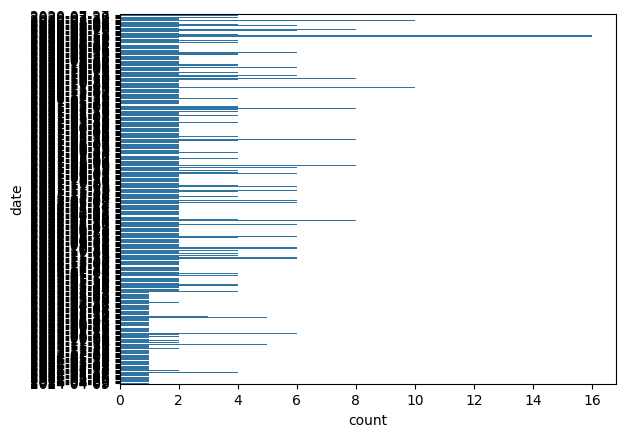

In [ ]:
sns.countplot(df.loc[pd.IndexSlice['A', :], :].reset_index()['date'])

In [ ]:
df.loc[pd.IndexSlice[:, '2020-07-28'], :]

title  \
ticker timestamp                                                                
A      2020-07-28 12:32:02  Ecolab : Second Quarter Reported Diluted Conti...   
       2020-07-28 12:32:02  Ecolab : Second Quarter Reported Diluted Conti...   
       2020-07-28 16:44:00  Charting a (bullish) holding pattern, S&P 500 ...   
       2020-07-28 16:44:00  Charting a (bullish) holding pattern, S&P 500 ...   
AAL    2020-07-28 00:00:00  Option Trading Volume Higher Than Underlying S...   
...                                                                       ...   
AMD    2020-07-28 22:07:04  Dow rises more than 100 points after Fed keeps...   
       2020-07-28 22:07:04  Dow rises more than 100 points after Fed keeps...   
       2020-07-28 22:22:19  Advanced Micro Devices, Inc. (AMD) CEO Lisa Su...   
       2020-07-28 22:22:19  Advanced Micro Devices, Inc. (AMD) CEO Lisa Su...   
AME    2020-07-28 16:33:04  Ametek (AME) Expected to Beat Earnings Estimat...   

                                                                         text  \
ticker timestamp                                                                
A      2020-07-28 12:32:02                                                NaN   
       2020-07-28 12:32:02                                                NaN   
       2020-07-28 16:44:00  The major U.S. benchmarks are acting well tech...   
       2020-07-28 16:44:00  The major U.S. benchmarks are acting well tech...   
AAL    2020-07-28 00:00:00  This year has been a year of firsts on Wall St...   
...                                                                       ...   
AMD    2020-07-28 22:07:04  Stocks rose on Wednesday as tech shares led th...   
       2020-07-28 22:07:04  Stocks rose on Wednesday as tech shares led th...   
       2020-07-28 22:22:19  Advanced Micro Devices, Inc. (AMD) CEO Lisa Su...   
       2020-07-28 22:22:19  Advanced Micro Devices, Inc. (AMD) CEO Lisa Su...   
AME    2020-07-28 16:33:04  Ametek (AME) possesses the right combination o...   

                                 date  
ticker timestamp                       
A      2020-07-28 12:32:02 2020-07-28  
       2020-07-28 12:32:02 2020-07-28  
       2020-07-28 16:44:00 2020-07-28  
       2020-07-28 16:44:00 2020-07-28  
AAL    2020-07-28 00:00:00 2020-07-28  
...                               ...  
AMD    2020-07-28 22:07:04 2020-07-28  
       2020-07-28 22:07:04 2020-07-28  
       2020-07-28 22:22:19 2020-07-28  
       2020-07-28 22:22:19 2020-07-28  
AME    2020-07-28 16:33:04 2020-07-28  

[155 rows x 3 columns]

In [ ]:
df[df['ticker'] == 'A']

,ticker,timestamp,title,text,date
0,A,2024-04-09 13:06:13,Agilent (A) is Set for Analytica 2024 With Adv...,Agilent (A) plans to showcase its new products...,2024-04-09
1,A,2024-04-05 10:56:07,Agilent (A) to Bolster DCG Segment With Upcomi...,Agilent (A) plans to introduce new solutions f...,2024-04-05
2,A,2024-04-02 12:15:15,Agilent (A) Boosts LSAG Segment With Advanced ...,Agilent (A) unveils ADS 2 to enhance workflow ...,2024-04-02
3,A,2024-03-29 10:31:40,Earnings Growth & Price Strength Make Agilent ...,"Wondering how to pick strong, market-beating s...",2024-03-29
4,A,2024-03-28 12:36:43,Agilent (A) Up 7.6% Since Last Earnings Report...,Agilent (A) reported earnings 30 days ago. Wha...,2024-03-28
...,...,...,...,...,...
777,A,2020-07-29 19:50:00,These ‘green’ stocks would thrive under a Bide...,‘Energy transformation will happen with or wit...,2020-07-29
778,A,2020-07-29 15:47:03,"Tractor Supply, Tanger Factory, Cisco, Agilent...","Tractor Supply, Tanger Factory, Cisco, Agilent...",2020-07-29
779,A,2020-07-28 16:44:00,"Charting a (bullish) holding pattern, S&P 500 ...",The major U.S. benchmarks are acting well tech...,2020-07-28
780,A,2020-07-28 12:32:02,Ecolab : Second Quarter Reported Diluted Conti...,NaN,2020-07-28


In [ ]:
df[df['ticker'] == 'A'].to_csv('data.csv', index=False)

In [ ]:
_df = df.value_counts()

_df[_df > 1].sort_index()

ticker  timestamp            title                                                                                              text                                                                                                                                                                                                                                                                                                                                              date      
A       2020-07-27 15:00:00  Agilent to Webcast Third-Quarter Fiscal Year 2020 Financial Results Conference Call                Agilent to webcast third-quarter financial results conference call August 18.                                                                                                                                                                                                                                                                     2020-07-27    2
        2020-07-28 16:44:00  Charting a (

In [ ]:
df.set_index(['ticker', 'date'], inplace=True)
df.sort_index(level=['ticker', 'date'], ascending=True, inplace=True)

df

timestamp  \
ticker date                             
A      2020-07-27 2020-07-27 15:00:00   
       2020-07-27 2020-07-27 15:00:00   
       2020-07-28 2020-07-28 16:44:00   
       2020-07-28 2020-07-28 12:32:02   
       2020-07-28 2020-07-28 16:44:00   
...                               ...   
AAPL   2024-04-13 2024-04-13 13:12:42   
       2024-04-13 2024-04-13 13:00:00   
       2024-04-13 2024-04-13 11:01:00   
       2024-04-13 2024-04-13 08:30:00   
       2024-04-14 2024-04-14 09:45:32   

                                                               title  \
ticker date                                                            
A      2020-07-27  Agilent to Webcast Third-Quarter Fiscal Year 2...   
       2020-07-27  Agilent to Webcast Third-Quarter Fiscal Year 2...   
       2020-07-28  Charting a (bullish) holding pattern, S&P 500 ...   
       2020-07-28  Ecolab : Second Quarter Reported Diluted Conti...   
       2020-07-28  Charting a (bullish) holding pattern, S&P 500 ...   
...                                                              ...   
AAPL   2024-04-13  Apple denies violating US court order in Epic ...   
       2024-04-13   3 Red-Hot Stocks With Long-Term Growth Potential   
       2024-04-13  3 Dow Jones Dividend Stocks That Are Within 6%...   
       2024-04-13          Stocks I'm Buying The Third Week Of April   
       2024-04-14  Wall Street Favorites: 3 Magnificent 7 Stocks ...   

                                                                text  
ticker date                                                           
A      2020-07-27  Agilent to webcast third-quarter financial res...  
       2020-07-27  Agilent to webcast third-quarter financial res...  
       2020-07-28  The major U.S. benchmarks are acting well tech...  
       2020-07-28                                                NaN  
       2020-07-28  The major U.S. benchmarks are acting well tech...  
...                                                              ...  
AAPL   2024-04-13  IPhone maker Apple on Friday denied violating ...  
       2024-04-13  Many value investors may ignore the red-hot st...  
       2024-04-13  Apple is simply too good a value to pass up. N...  
       2024-04-13  Job gains in March mainly came from immigrants...  
       2024-04-14  The Magnificent 7 stocks stood head and should...  

[10001 rows x 3 columns]

In [ ]:
df.to_csv('data.csv')

In [ ]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
tokens = tokenizer.tokenize('[SEP] Agilent ([UNK]) is Set for Analytica 2024')

len(tokens)

13

In [ ]:
input_ids = tokenizer.encode(
    text='Agilent (A) is Set for Analytica 2024',
    text_pair='Apple lost nearly $200B in market cap',
    add_special_tokens=True,
)

input_tokens = tokenizer.decode(input_ids)

print(input_ids)
print(input_tokens)

[101, 29003, 3372, 1006, 1037, 1007, 2003, 2275, 2005, 23521, 2050, 16798, 2549, 102, 6207, 2439, 3053, 1002, 3263, 2497, 1999, 3006, 6178, 102]
[CLS] agilent ( a ) is set for analytica 2024 [SEP] apple lost nearly $ 200b in market cap [SEP]


In [ ]:
batch_title = df_news.loc[:3, 'title'].tolist()
batch_text = df_news.loc[:3, 'text'].tolist()

batch = tokenizer(
    text=batch_title,
    text_pair=batch_text,
    add_special_tokens=True,
    padding=True,
    truncation=True,
    max_length=512,
    return_tensors='pt',
)

input_ids = batch['input_ids']
input_tokens = tokenizer.batch_decode(input_ids)

input_tokens

['[CLS] agilent ( a ) is set for analytica 2024 with advanced products [SEP] agilent ( a ) plans to showcase its new products for analytical laboratories at analytica 2024, boosting its overall product portfolio. [SEP] [PAD]',
 '[CLS] agilent ( a ) to bolster dcg segment with upcoming solutions [SEP] agilent ( a ) plans to introduce new solutions for cancer research and diagnosis, boosting its dcg segment. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] agilent ( a ) boosts lsag segment with advanced dilution system [SEP] agilent ( a ) unveils ads 2 to enhance workflow efficiency within the laboratory, boosting the lsag segment. [SEP]',
 '[CLS] earnings growth & price strength make agilent technologies ( a ) a stock to watch [SEP] wondering how to pick strong, market - beating stocks for your investment portfolio? look no further than the zacks focus list. [SEP] [PAD] [PAD]']

In [ ]:
input_ids

tensor([[  101, 29003,  3372,  1006,  1037,  1007,  2003,  2275,  2005, 23521,
          2050, 16798,  2549,  2007,  3935,  3688,   102, 29003,  3372,  1006,
          1037,  1007,  3488,  2000, 13398,  2049,  2047,  3688,  2005, 17826,
         12030,  2012, 23521,  2050, 16798,  2549,  1010, 12992,  2075,  2049,
          3452,  4031, 11103,  1012,   102,     0],
        [  101, 29003,  3372,  1006,  1037,  1007,  2000,  8945, 29576,  5887,
          2290,  6903,  2007,  9046,  7300,   102, 29003,  3372,  1006,  1037,
          1007,  3488,  2000,  8970,  2047,  7300,  2005,  4456,  2470,  1998,
         11616,  1010, 12992,  2075,  2049,  5887,  2290,  6903,  1012,   102,
             0,     0,     0,     0,     0,     0],
        [  101, 29003,  3372,  1006,  1037,  1007, 12992,  2015,  1048,  3736,
          2290,  6903,  2007,  3935, 29454, 13700,  2291,   102, 29003,  3372,
          1006,  1037,  1007,  4895,  3726, 12146, 14997,  1016,  2000, 11598,
          2147, 12314,  812

In [ ]:
batch

{'input_ids': tensor([[  101, 29003,  3372,  1006,  1037,  1007,  2003,  2275,  2005, 23521,
          2050, 16798,  2549,  2007,  3935,  3688,   102, 29003,  3372,  1006,
          1037,  1007,  3488,  2000, 13398,  2049,  2047,  3688,  2005, 17826,
         12030,  2012, 23521,  2050, 16798,  2549,  1010, 12992,  2075,  2049,
          3452,  4031, 11103,  1012,   102,     0],
        [  101, 29003,  3372,  1006,  1037,  1007,  2000,  8945, 29576,  5887,
          2290,  6903,  2007,  9046,  7300,   102, 29003,  3372,  1006,  1037,
          1007,  3488,  2000,  8970,  2047,  7300,  2005,  4456,  2470,  1998,
         11616,  1010, 12992,  2075,  2049,  5887,  2290,  6903,  1012,   102,
             0,     0,     0,     0,     0,     0],
        [  101, 29003,  3372,  1006,  1037,  1007, 12992,  2015,  1048,  3736,
          2290,  6903,  2007,  3935, 29454, 13700,  2291,   102, 29003,  3372,
          1006,  1037,  1007,  4895,  3726, 12146, 14997,  1016,  2000, 11598,
          214

In [ ]:
output = model(
    **batch,
    return_dict=True,
    output_attentions=True,
    output_hidden_states=True,
)

In [ ]:
output.logits

tensor([[-0.9940, -0.7390, -0.9997,  ..., -0.9964, -0.6550,  0.9900],
        [-0.9885, -0.5107, -0.9994,  ..., -0.9960, -0.2239,  0.9838],
        [-0.9883, -0.4851, -0.9993,  ..., -0.9952, -0.3842,  0.9777],
        [-0.7581,  0.0337,  0.9029,  ..., -0.0987,  0.2569,  0.8831]],
       grad_fn=<TanhBackward0>)

In [ ]:
output.logits

In [ ]:
attentions = output.attentions

len(attentions), attentions[0].shape

(12, torch.Size([4, 12, 46, 46]))

In [ ]:
hidden_states = output.hidden_states

len(hidden_states), hidden_states[0].shape

(13, torch.Size([4, 46, 768]))

In [ ]:
# Embedding sources:
# > 1. Last hidden state of the model
sentiment = hidden_states[-1][:, 0, :]

# > 2. Take out last layer and use pure pooled data
model.classifier = nn.Identity()

output = model(
    **batch,
    return_dict=True,
    output_attentions=True,
    output_hidden_states=True,
)

sentiment = output.logits

# > 3. Substitute classifier layer for a projector
model.classifier = nn.Linear(768, 128)
# Or leave nn.Identity and add projector in a super model

output = model(
    **batch,
    return_dict=True,
    output_attentions=True,
    output_hidden_states=True,
)

sentiment = output.logits

tensor([[-0.6463,  0.4585, -1.0464,  ..., -1.4115,  0.0547, -0.1326],
        [-0.4318,  0.2625, -0.8613,  ..., -1.4880, -0.2003, -0.1260],
        [-0.7014,  0.3031, -1.0732,  ..., -1.4064, -0.2133, -0.1643],
        [ 0.2504, -0.2560, -0.7295,  ..., -0.7689, -0.6160,  0.2245]],
       grad_fn=<SliceBackward0>)

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
tokens = tokenizer.tokenize('[SEP] Agilent ([UNK]) is Set for Analytica 2024', return_tensors='pt')

len(tokens)

13

## Time Series

In [ ]:
class TimeSeriesDataset(Dataset):

    def __init__(self, tickers):

        self.tickers = tickers
        self.keys = ['prices', 'metrics', 'profile']

        repo_id = 'halaction/finformer-data'

        for key in self.keys:

            filename = f'dataset/{key}.csv'

            path = hf_hub_download(repo_id=repo_id, filename=filename, repo_type='dataset')
            df = pd.read_csv(path)

            df = df[df['symbol'].isin(self.tickers)]

            setattr(self, key, df)

    def __len__(self):
        pass

    def __getitem__(self, index):
        pass


In [ ]:
tickers = get_tickers()
dataset = TimeSeriesDataset(tickers)

df_prices = dataset.prices
df_profile = dataset.profile
df_metrics = dataset.metrics

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
columns = ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume']
df = df_prices[columns]

df = df.rename(columns={
    'symbol': 'ticker',
    'date': 'timestamp',
})

df = df[df['ticker'].isin(tickers)]

df['date'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d')

df = df.drop(columns=['timestamp', ])

start = pd.to_datetime('2010-01-01', format='%Y-%m-%d')
end = pd.to_datetime('2024-04-15', format='%Y-%m-%d')
date_index = pd.date_range(start=start, end=end, freq='D')

levels = ['date', ]
df_list = []
for ticker_tuple, df_ticker in df.groupby(by=['ticker']):
    ticker = ticker_tuple[0]

    df_ticker.set_index(levels, inplace=True)
    df.sort_index(level=levels, ascending=True, inplace=True)
    df_ticker = df_ticker.reindex(date_index)
    df_ticker.reset_index(names=levels, inplace=True)

    df_ticker['ticker'] = ticker

    df_list.append(df_ticker)

df = pd.concat(df_list, axis=0)

levels = ['ticker', 'date']
df.set_index(levels, inplace=True)
df.sort_index(level=levels, ascending=True, inplace=True)

In [ ]:
df_prices

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime,symbol
0,2024-04-15,142.31,143.25,140.26,140.34,140.34,433934,433934,-1.97,-1.38430,141.2800,"April 15, 24",-0.013843,A
1,2024-04-12,143.59,144.66,140.26,140.73,140.73,1124506,1124506,-2.86,-1.99000,142.3100,"April 12, 24",-0.019900,A
2,2024-04-11,145.65,145.86,143.67,145.00,145.00,720175,720175,-0.65,-0.44628,145.0450,"April 11, 24",-0.004463,A
3,2024-04-10,144.42,145.06,143.55,144.16,144.16,1051822,1051822,-0.26,-0.18003,144.2975,"April 10, 24",-0.001800,A
4,2024-04-09,146.00,147.43,145.50,147.40,147.40,873691,873691,1.40,0.95890,146.5825,"April 09, 24",0.009589,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1763915,2013-02-07,31.00,32.73,31.00,32.00,29.54,3800800,3800800,1.00,3.23000,31.9100,"February 07, 13",0.032300,ZTS
1763916,2013-02-06,30.98,31.43,30.75,31.03,28.64,2126100,2126100,0.05,0.16139,31.0700,"February 06, 13",0.001614,ZTS
1763917,2013-02-05,31.25,31.98,30.85,31.04,28.65,5013200,5013200,-0.21,-0.67200,31.2900,"February 05, 13",-0.006720,ZTS
1763918,2013-02-04,31.09,31.99,30.76,31.02,28.64,7695400,7695400,-0.07,-0.22515,31.2600,"February 04, 13",-0.002252,ZTS


In [ ]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763920 entries, 0 to 1763919
Data columns (total 14 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   open              float64
 2   high              float64
 3   low               float64
 4   close             float64
 5   adjClose          float64
 6   volume            int64  
 7   unadjustedVolume  int64  
 8   change            float64
 9   changePercent     float64
 10  vwap              float64
 11  label             object 
 12  changeOverTime    float64
 13  symbol            object 
dtypes: float64(9), int64(2), object(3)
memory usage: 188.4+ MB


In [ ]:
columns = ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume']
df = df_prices[columns]

df = df.rename(columns={
    'symbol': 'ticker',
    'date': 'timestamp',
})

df = df[df['ticker'].isin(tickers)]

df['date'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d')

df = df.drop(columns=['timestamp', ])

start = pd.to_datetime(config.start_date, format='%Y-%m-%d')
end = pd.to_datetime(config.end_date, format='%Y-%m-%d')
date_index = pd.date_range(start=start, end=end, freq='D')

levels = ['ticker', 'date']
df.set_index(levels, inplace=True)
df.sort_index(level=levels, ascending=True, inplace=True)

df = df.loc[pd.IndexSlice[:, start:end], :]

index = pd.MultiIndex.from_product(
    [df.index.get_level_values('ticker').unique(), date_index],
    names=levels,
)

df = df.reindex(index)

df

open    high     low   close      volume
ticker date                                                  
A      2020-01-01     NaN     NaN     NaN     NaN         NaN
       2020-01-02   85.90   86.35   85.20   85.95   1392522.0
       2020-01-03   84.67   85.33   84.50   84.57   1118322.0
       2020-01-04     NaN     NaN     NaN     NaN         NaN
       2020-01-05     NaN     NaN     NaN     NaN         NaN
...                   ...     ...     ...     ...         ...
ZTS    2024-04-11  163.32  164.29  161.26  162.73   2290438.0
       2024-04-12  155.85  155.98  148.48  149.98  11577753.0
       2024-04-13     NaN     NaN     NaN     NaN         NaN
       2024-04-14     NaN     NaN     NaN     NaN         NaN
       2024-04-15  151.12  154.93  150.73  153.11   3433145.0

[814840 rows x 5 columns]

In [ ]:
df.index.get_level_values('ticker'), date_index

(Index(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
        ...
        'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS', 'ZTS'],
       dtype='object', name='ticker', length=554330),
 DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
                '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
                '2020-01-09', '2020-01-10',
                ...
                '2024-04-06', '2024-04-07', '2024-04-08', '2024-04-09',
                '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-13',
                '2024-04-14', '2024-04-15'],
               dtype='datetime64[ns]', length=1567, freq='D'))

In [ ]:
index = pd.MultiIndex.from_product(
    [df.index.get_level_values('ticker'), date_index],
    names=levels,
)



In [ ]:
df.info()

In [ ]:
df

In [ ]:
df.loc[pd.IndexSlice['A', '2010-01-01':'2010-01-30'], :]

open   high    low  close     volume
ticker date                                             
A      2010-01-01    NaN    NaN    NaN    NaN        NaN
       2010-01-02    NaN    NaN    NaN    NaN        NaN
       2010-01-03    NaN    NaN    NaN    NaN        NaN
       2010-01-04  22.45  22.62  22.26  22.38  3816654.0
       2010-01-05  22.32  22.33  22.00  22.14  4187234.0
       2010-01-06  22.06  22.17  22.00  22.06  3244778.0
       2010-01-07  22.01  22.04  21.81  22.03  3096024.0
       2010-01-08  21.91  22.06  21.74  22.02  3735008.0
       2010-01-09    NaN    NaN    NaN    NaN        NaN
       2010-01-10    NaN    NaN    NaN    NaN        NaN
       2010-01-11  22.08  22.20  21.93  22.04  4782995.0
       2010-01-12  21.85  21.92  21.61  21.77  2871926.0
       2010-01-13  21.79  22.01  21.49  21.95  3419944.0
       2010-01-14  21.87  22.34  21.81  22.27  6165585.0
       2010-01-15  22.33  22.43  21.69  21.76  4628015.0
       2010-01-16    NaN    NaN    NaN    NaN        NaN
       2010-01-17    NaN    NaN    NaN    NaN        NaN
       2010-01-18    NaN    NaN    NaN    NaN        NaN
       2010-01-19  21.71  22.05  21.70  22.02  3564729.0
       2010-01-20  21.83  21.93  21.59  21.90  4590487.0
       2010-01-21  22.17  22.25  21.58  21.82  6083181.0
       2010-01-22  21.70  21.70  20.80  20.86  4264335.0
       2010-01-23    NaN    NaN    NaN    NaN        NaN
       2010-01-24    NaN    NaN    NaN    NaN        NaN
       2010-01-25  21.04  21.20  20.90  21.06  3609584.0
       2010-01-26  21.00  21.10  20.72  20.94  2697600.0
       2010-01-27  20.88  20.94  20.54  20.86  4363462.0
       2010-01-28  20.83  21.00  20.37  20.52  4939383.0
       2010-01-29  20.69  20.86  19.97  20.04  5924786.0
       2010-01-30    NaN    NaN    NaN    NaN        NaN

In [ ]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction


config = TimeSeriesTransformerConfig(
    prediction_length=30,
    context_length=60,
    lags_sequence=list(range(1, 7 + 1)),
    num_time_features=0,
    num_static_categorical_features=1,
    cardinality=[len(tickers)],
    embedding_dimension=[16],
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [ ]:
model

TimeSeriesTransformerForPrediction(
  (model): TimeSeriesTransformerModel(
    (scaler): TimeSeriesMeanScaler()
    (embedder): TimeSeriesFeatureEmbedder(
      (embedders): ModuleList(
        (0): Embedding(520, 16)
      )
    )
    (encoder): TimeSeriesTransformerEncoder(
      (value_embedding): TimeSeriesValueEmbedding(
        (value_projection): Linear(in_features=25, out_features=32, bias=False)
      )
      (embed_positions): TimeSeriesSinusoidalPositionalEmbedding(90, 32)
      (layers): ModuleList(
        (0-3): 4 x TimeSeriesTransformerEncoderLayer(
          (self_attn): TimeSeriesTransformerAttention(
            (k_proj): Linear(in_features=32, out_features=32, bias=True)
            (v_proj): Linear(in_features=32, out_features=32, bias=True)
            (q_proj): Linear(in_features=32, out_features=32, bias=True)
            (out_proj): Linear(in_features=32, out_features=32, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((32,), eps=1e-05, elemen

In [ ]:
df_small = df.loc[pd.IndexSlice[:, '2020-01-01':'2024-04-01'], :]

In [ ]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 807560 entries, ('A', Timestamp('2020-01-01 00:00:00')) to ('ZTS', Timestamp('2024-04-01 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    549140 non-null  float64
 1   high    549140 non-null  float64
 2   low     549140 non-null  float64
 3   close   549140 non-null  float64
 4   volume  549140 non-null  float64
dtypes: float64(5)
memory usage: 33.9+ MB


In [ ]:
df_small

open    high     low   close     volume
ticker date                                                 
A      2020-01-01     NaN     NaN     NaN     NaN        NaN
       2020-01-02   85.90   86.35   85.20   85.95  1392522.0
       2020-01-03   84.67   85.33   84.50   84.57  1118322.0
       2020-01-04     NaN     NaN     NaN     NaN        NaN
       2020-01-05     NaN     NaN     NaN     NaN        NaN
...                   ...     ...     ...     ...        ...
ZTS    2024-03-28  168.73  171.14  167.41  169.21  3395781.0
       2024-03-29     NaN     NaN     NaN     NaN        NaN
       2024-03-30     NaN     NaN     NaN     NaN        NaN
       2024-03-31     NaN     NaN     NaN     NaN        NaN
       2024-04-01  168.99  169.49  166.12  167.02  1896520.0

[807560 rows x 5 columns]

In [ ]:
df_small = df[:100_000].copy()
df_small.loc[:, 'date'] = pd.to_datetime(df_small['date'], format='%Y-%m-%d')

levels = ['ticker', 'date']
df_small.set_index(levels, inplace=True)
df_small.sort_index(level=levels, ascending=True, inplace=True)

In [ ]:
df_small

open      high     low   close   volume
ticker date                                                 
A      2010-01-04   22.45   22.6200   22.26   22.38  3816654
       2010-01-05   22.32   22.3300   22.00   22.14  4187234
       2010-01-06   22.06   22.1700   22.00   22.06  3244778
       2010-01-07   22.01   22.0400   21.81   22.03  3096024
       2010-01-08   21.91   22.0600   21.74   22.02  3735008
...                   ...       ...     ...     ...      ...
AMGN   2024-04-09  270.19  271.2900  268.58  270.36  1792627
       2024-04-10  267.96  268.3800  264.63  266.45  1949622
       2024-04-11  270.22  273.0000  268.45  270.00  2169844
       2024-04-12  268.77  269.3000  266.17  267.28  2140134
       2024-04-15  269.93  270.9289  266.29  267.39   491753

[100000 rows x 5 columns]

In [ ]:
df_small.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 100000 entries, ('A', Timestamp('2024-04-15 00:00:00')) to ('AMGN', Timestamp('2020-12-11 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    100000 non-null  float64
 1   high    100000 non-null  float64
 2   low     100000 non-null  float64
 3   close   100000 non-null  float64
 4   volume  100000 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 4.3+ MB


## Past Values

In [ ]:
tickers = df_small.index.get_level_values('ticker').unique()
n_tickers = len(tickers)
ticker_ids = np.random.choice(n_tickers, 10)

ticker_index = tickers[ticker_ids]

ticker_index

Index(['DTE', 'PSX', 'BK', 'EA', 'PH', 'IRM', 'PCAR', 'NEE', 'UDR', 'ELV'], dtype='object', name='ticker')

In [ ]:
context_length = 60
prediction_length = 30

context_start = pd.to_datetime(config.start_date, format='%Y-%m-%d')
context_delta = pd.to_timedelta(context_length - 1, unit='D')
context_end = context_start + context_delta
context_index = pd.date_range(start=context_start, end=context_end, freq='D')

context_index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
               '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
               '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
               '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
               '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
               '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
               '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
      

In [ ]:
columns = ['open', 'close', 'volume']

In [ ]:
df_context = df_small.loc[pd.IndexSlice[ticker_index, context_index], columns]

df_context

open   close     volume
ticker date                                 
DTE    2020-01-01     NaN     NaN        NaN
       2020-01-02  110.61  109.50  1097278.0
       2020-01-03  109.27  109.77  1367959.0
       2020-01-04     NaN     NaN        NaN
       2020-01-05     NaN     NaN        NaN
...                   ...     ...        ...
ELV    2020-02-25  279.21  267.40  1954896.0
       2020-02-26  269.84  268.15  1733219.0
       2020-02-27  263.06  257.86  2329027.0
       2020-02-28  249.94  257.09  2984016.0
       2020-02-29     NaN     NaN        NaN

[600 rows x 3 columns]

In [ ]:
past_values

In [ ]:
batch_shape = len(ticker_index), len(context_index), len(columns)

past_values = torch.tensor(df_context.values).view(batch_shape)

past_values

tensor([[[       nan,        nan,        nan],
         [1.1061e+02, 1.0950e+02, 1.0973e+06],
         [1.0927e+02, 1.0977e+02, 1.3680e+06],
         ...,
         [1.0552e+02, 1.0041e+02, 2.6420e+06],
         [9.8960e+01, 9.5010e+01, 3.4175e+06],
         [       nan,        nan,        nan]],

        [[       nan,        nan,        nan],
         [1.1208e+02, 1.1220e+02, 1.6079e+06],
         [1.1125e+02, 1.0849e+02, 2.2369e+06],
         ...,
         [7.8700e+01, 7.4260e+01, 6.9005e+06],
         [7.1700e+01, 7.4860e+01, 7.1378e+06],
         [       nan,        nan,        nan]],

        [[       nan,        nan,        nan],
         [5.0460e+01, 5.0920e+01, 2.5872e+06],
         [5.0260e+01, 5.0270e+01, 2.2761e+06],
         ...,
         [4.0510e+01, 4.0960e+01, 1.1049e+07],
         [3.9520e+01, 3.9900e+01, 1.4488e+07],
         [       nan,        nan,        nan]],

        ...,

        [[       nan,        nan,        nan],
         [6.0490e+01, 5.9650e+01, 7.8848e+06]

In [ ]:
df_context.values

(600, 5)

In [ ]:
df_context = df_small.loc[pd.IndexSlice[ticker_index, context_index], ['open', 'close']]

tensor_list = []

for _ticker, _df in df_context.groupby(by=['ticker']):

    ticker_tensor = torch.tensor(_df.values).unsqueeze(0)
    tensor_list.append(ticker_tensor)

past_values = torch.cat(tensor_list, dim=0)
past_values.shape

torch.Size([10, 60, 2])

In [ ]:
past_values

tensor([[[     nan,      nan],
         [     nan,      nan],
         [     nan,      nan],
         ...,
         [     nan,      nan],
         [     nan,      nan],
         [165.4300, 166.0000]],

        [[     nan,      nan],
         [     nan,      nan],
         [     nan,      nan],
         ...,
         [     nan,      nan],
         [     nan,      nan],
         [ 25.4700,  25.6000]],

        [[     nan,      nan],
         [     nan,      nan],
         [     nan,      nan],
         ...,
         [     nan,      nan],
         [     nan,      nan],
         [ 30.4900,  30.6500]],

        ...,

        [[     nan,      nan],
         [     nan,      nan],
         [     nan,      nan],
         ...,
         [     nan,      nan],
         [     nan,      nan],
         [ 31.8900,  32.0600]],

        [[     nan,      nan],
         [     nan,      nan],
         [     nan,      nan],
         ...,
         [     nan,      nan],
         [     nan,      nan],
         

## Past Observed Mask

In [ ]:
past_observed_mask = past_values.isnan()

past_observed_mask

tensor([[[ True,  True],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [False, False]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [False, False]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [False, False]],

        ...,

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [False, False]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [False, False]],

        [[ True,  True],
         [ True,  True],
         [ True,  True],
         ...,
         [ True,  True],
         [ True,  True],
         [False, 

## Past Time Features

In [ ]:
df

open    high     low   close      volume
ticker date                                                  
A      2010-01-01     NaN     NaN     NaN     NaN         NaN
       2010-01-02     NaN     NaN     NaN     NaN         NaN
       2010-01-03     NaN     NaN     NaN     NaN         NaN
       2010-01-04   22.45   22.62   22.26   22.38   3816654.0
       2010-01-05   22.32   22.33   22.00   22.14   4187234.0
...                   ...     ...     ...     ...         ...
ZTS    2024-04-11  163.32  164.29  161.26  162.73   2290438.0
       2024-04-12  155.85  155.98  148.48  149.98  11577753.0
       2024-04-13     NaN     NaN     NaN     NaN         NaN
       2024-04-14     NaN     NaN     NaN     NaN         NaN
       2024-04-15  151.12  154.93  150.73  153.11   3433145.0

[2713880 rows x 5 columns]

In [ ]:
df_time = pd.DataFrame(df.index.get_level_values('date').unique(), columns=['date'])

df_time['weekday'] = df_time['date'].dt.day_name()
df_time['month'] = df_time['date'].dt.month_name()
df_time['days_in_month'] = df_time['date'].dt.days_in_month
df_time['is_month_end'] = df_time['date'].dt.is_month_end
df_time['quarter'] = df_time['date'].dt.quarter
df_time['is_quarter_end'] = df_time['date'].dt.is_quarter_end
df_time['age'] = df_time['date'].dt.year - 2010

cat_columns = ['weekday', 'month', 'quarter']
df_time = pd.get_dummies(df_time, columns=cat_columns, drop_first=True)

# TODO: Add macro
# TODO: Add news

df_time

,date,days_in_month,is_month_end,is_quarter_end,age,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,...,month_July,month_June,month_March,month_May,month_November,month_October,month_September,quarter_2,quarter_3,quarter_4
0,2010-01-01,31,False,False,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2010-01-02,31,False,False,0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2010-01-03,31,False,False,0,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2010-01-04,31,False,False,0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2010-01-05,31,False,False,0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5214,2024-04-11,30,False,False,14,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
5215,2024-04-12,30,False,False,14,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
5216,2024-04-13,30,False,False,14,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
5217,2024-04-14,30,False,False,14,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False


## Static Categorical Features

In [ ]:
df_profile

,symbol,price,beta,volAvg,mktCap,lastDiv,range,changes,companyName,currency,...,zip,dcfDiff,dcf,image,ipoDate,defaultImage,isEtf,isActivelyTrading,isAdr,isFund
0,A,140.73,1.122,1580247,41241630150,0.94,96.8-151.58,-4.27,"Agilent Technologies, Inc.",USD,...,95051,54.30828,86.421721,https://financialmodelingprep.com/image-stock/...,1999-11-18,False,False,True,False,False
1,AAL,13.15,1.569,32945968,8610054550,0.00,10.86-19.08,-0.47,American Airlines Group Inc.,USD,...,76155,2.01582,14.414200,https://financialmodelingprep.com/image-stock/...,2005-09-27,False,False,True,False,False
2,AAPL,176.55,1.276,61107580,2726267445000,0.96,162.8-199.62,1.51,Apple Inc.,USD,...,95014,43.71575,132.834249,https://financialmodelingprep.com/image-stock/...,1980-12-12,False,False,True,False,False
3,ABBV,162.28,0.564,5623340,287341082000,6.20,130.96-182.89,-3.69,AbbVie Inc.,USD,...,60064-6400,-901.28211,1063.372112,https://financialmodelingprep.com/image-stock/...,2013-01-02,False,False,True,False,False
4,ABNB,159.37,1.254,4884288,103158167758,0.00,103.55-170.1,-6.05,"Airbnb, Inc.",USD,...,94103,34.28530,125.084696,https://financialmodelingprep.com/image-stock/...,2020-12-10,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,ZS,181.41,0.815,2409127,27185739780,0.00,84.93-259.61,-3.37,"Zscaler, Inc.",USD,...,95134,-4.96356,186.373557,https://financialmodelingprep.com/image-stock/...,2018-03-16,False,False,True,False,False
516,ZTS,149.98,0.848,2895765,68670892660,1.73,148.48-201.92,-12.75,Zoetis Inc.,USD,...,07054,43.22274,106.757259,https://financialmodelingprep.com/image-stock/...,2013-02-01,False,False,True,False,False
517,BRO,81.90,0.781,1305608,23407183800,0.52,58.48-87.99,-0.75,"Brown & Brown, Inc.",USD,...,32114,-36.19598,118.095977,https://financialmodelingprep.com/image-stock/...,1981-02-11,False,False,True,False,False
518,JBL,134.07,1.392,1296080,16168439790,0.32,75.48-156.94,-3.95,Jabil Inc.,USD,...,33716,92.98870,41.081296,https://financialmodelingprep.com/image-stock/...,1993-05-03,False,False,True,False,False


In [ ]:
df_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 36 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symbol             520 non-null    object 
 1   price              520 non-null    float64
 2   beta               520 non-null    float64
 3   volAvg             520 non-null    int64  
 4   mktCap             520 non-null    int64  
 5   lastDiv            520 non-null    float64
 6   range              520 non-null    object 
 7   changes            520 non-null    float64
 8   companyName        519 non-null    object 
 9   currency           520 non-null    object 
 10  cik                517 non-null    float64
 11  isin               520 non-null    object 
 12  cusip              509 non-null    object 
 13  exchange           520 non-null    object 
 14  exchangeShortName  520 non-null    object 
 15  industry           519 non-null    object 
 16  website            517 non

In [ ]:
# TODO: Think about what you can do with descrpition w/ or w/o LLM
columns = ['symbol', 'industry', 'sector', 'country', 'ipoDate']

df = df_profile[columns]

df = df.rename(columns={
    'symbol': 'ticker',
    'ipoDate': 'date_ipo',
})

df['date_ipo'] = pd.to_datetime(df['date_ipo'], format='%Y-%m-%d')
df['_max_date_ipo'] = df['date_ipo'].max()

df['age_ipo'] = df['_max_date_ipo'] - df['date_ipo']

df = df.drop(columns=['date_ipo', '_max_date_ipo'])

# Hardcoding missing values
df.loc[df['ticker'] == 'SOLV', 'sector'] = 'Healthcare'
df.loc[df['ticker'] == 'SOLV', 'industry'] = 'Medical - Healthcare Information Services'
df.loc[df['country'].isna(), 'country'] = 'US'

levels = ['ticker', ]
df.set_index(levels, inplace=True)
df.sort_index(level=levels, ascending=True, inplace=True)

df

,industry,sector,country,age_ipo
ticker,,,,
A,Medical - Diagnostics & Research,Healthcare,US,8721 days
AAL,"Airlines, Airports & Air Services",Industrials,US,6581 days
AAPL,Consumer Electronics,Technology,US,15636 days
ABBV,Drug Manufacturers - General,Healthcare,US,3927 days
ABNB,Travel Services,Consumer Cyclical,US,1028 days
...,...,...,...,...
YUM,Restaurants,Consumer Cyclical,US,9513 days
ZBH,Medical - Devices,Healthcare,US,8106 days
ZBRA,Communication Equipment,Technology,US,11738 days


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 520 entries, A to ZTS
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype          
---  ------    --------------  -----          
 0   industry  520 non-null    object         
 1   sector    520 non-null    object         
 2   country   520 non-null    object         
 3   age_ipo   520 non-null    timedelta64[ns]
dtypes: object(3), timedelta64[ns](1)
memory usage: 20.3+ KB


In [ ]:
from sklearn.preprocessing import LabelEncoder


columns = ['sector', 'industry', 'country']
label_encoders = {column: LabelEncoder() for column in columns}

for column, encoder in label_encoders.items():
    df[f'{column}_id'] = encoder.fit_transform(df[column])

df = df.drop(columns=columns)

In [ ]:
ticker_index = ['A', 'MSFT', 'NVDA']
columns = ['sector_id', 'industry_id', 'country_id']

static_categorical_features = torch.tensor(df.loc[ticker_index, columns].values).long()
static_categorical_features

tensor([[  6,  68,   8],
        [  9, 102,   8],
        [  9, 100,   8]])

In [ ]:
sectors = [
    'Basic Materials',
    'Communication Services',
    'Consumer Cyclical',
    'Consumer Defensive',
    'Energy',
    'Financial Services',
    'Healthcare',
    'Industrials',
    'Real Estate',
    'Technology',
    'Utilities'
]

industries = [
    'Steel',
    'Silver',
    'Other Precious Metals',
    'Gold',
    'Copper',
    'Aluminum',
    'Paper, Lumber & Forest Products',
    'Industrial Materials',
    'Construction Materials',
    'Chemicals - Specialty',
    'Chemicals',
    'Agricultural Inputs',
    'Telecommunications Services',
    'Internet Content & Information',
    'Publishing',
    'Broadcasting',
    'Advertising Agencies',
    'Entertainment',
    'Travel Lodging',
    'Travel Services',
    'Specialty Retail',
    'Luxury Goods',
    'Home Improvement',
    'Residential Construction',
    'Department Stores',
    'Personal Products & Services',
    'Leisure',
    'Gambling, Resorts & Casinos',
    'Furnishings, Fixtures & Appliances',
    'Restaurants',
    'Auto - Parts',
    'Auto - Manufacturers',
    'Auto - Recreational Vehicles',
    'Auto - Dealerships',
    'Apparel - Retail',
    'Apparel - Manufacturers',
    'Apparel - Footwear & Accessories',
    'Packaging & Containers',
    'Tobacco',
    'Grocery Stores',
    'Discount Stores',
    'Household & Personal Products',
    'Packaged Foods',
    'Food Distribution',
    'Food Confectioners',
    'Agricultural Farm Products',
    'Education & Training Services',
    'Beverages - Wineries & Distilleries',
    'Beverages - Non-Alcoholic',
    'Beverages - Alcoholic',
    'Uranium',
    'Solar',
    'Oil & Gas Refining & Marketing',
    'Oil & Gas Midstream',
    'Oil & Gas Integrated',
    'Oil & Gas Exploration & Production',
    'Oil & Gas Equipment & Services',
    'Oil & Gas Energy',
    'Oil & Gas Drilling',
    'Coal',
    'Shell Companies',
    'Investment - Banking & Investment Services',
    'Insurance - Specialty',
    'Insurance - Reinsurance',
    'Insurance - Property & Casualty',
    'Insurance - Life',
    'Insurance - Diversified',
    'Insurance - Brokers',
    'Financial - Mortgages',
    'Financial - Diversified',
    'Financial - Data & Stock Exchanges',
    'Financial - Credit Services',
    'Financial - Conglomerates',
    'Financial - Capital Markets',
    'Banks - Regional',
    'Banks - Diversified',
    'Banks',
    'Asset Management',
    'Asset Management - Bonds',
    'Asset Management - Income',
    'Asset Management - Leveraged',
    'Asset Management - Cryptocurrency',
    'Asset Management - Global',
    'Medical - Specialties',
    'Medical - Pharmaceuticals',
    'Medical - Instruments & Supplies',
    'Medical - Healthcare Plans',
    'Medical - Healthcare Information Services',
    'Medical - Equipment & Services',
    'Medical - Distribution',
    'Medical - Diagnostics & Research',
    'Medical - Devices',
    'Medical - Care Facilities',
    'Drug Manufacturers - Specialty & Generic',
    'Drug Manufacturers - General',
    'Biotechnology',
    'Waste Management',
    'Trucking',
    'Railroads',
    'Aerospace & Defense',
    'Marine Shipping',
    'Integrated Freight & Logistics',
    'Airlines, Airports & Air Services',
    'General Transportation',
    'Manufacturing - Tools & Accessories',
    'Manufacturing - Textiles',
    'Manufacturing - Miscellaneous',
    'Manufacturing - Metal Fabrication',
    'Industrial - Distribution',
    'Industrial - Specialties',
    'Industrial - Pollution & Treatment Controls',
    'Environmental Services',
    'Industrial - Machinery',
    'Industrial - Infrastructure Operations',
    'Industrial - Capital Goods',
    'Consulting Services',
    'Business Equipment & Supplies',
    'Staffing & Employment Services',
    'Rental & Leasing Services',
    'Engineering & Construction',
    'Security & Protection Services',
    'Specialty Business Services',
    'Construction',
    'Conglomerates',
    'Electrical Equipment & Parts',
    'Agricultural - Machinery',
    'Agricultural - Commodities/Milling',
    'REIT - Specialty',
    'REIT - Retail',
    'REIT - Residential',
    'REIT - Office',
    'REIT - Mortgage',
    'REIT - Industrial',
    'REIT - Hotel & Motel',
    'REIT - Healthcare Facilities',
    'REIT - Diversified',
    'Real Estate - Services',
    'Real Estate - Diversified',
    'Real Estate - Development',
    'Real Estate - General',
    'Information Technology Services',
    'Hardware, Equipment & Parts',
    'Computer Hardware',
    'Electronic Gaming & Multimedia',
    'Software - Services',
    'Software - Infrastructure',
    'Software - Application',
    'Semiconductors',
    'Media & Entertainment',
    'Communication Equipment',
    'Technology Distributors',
    'Consumer Electronics',
    'Renewable Utilities',
    'Regulated Water',
    'Regulated Gas',
    'Regulated Electric',
    'Independent Power Producers',
    'Diversified Utilities',
    'General Utilities',
]

## Static Real Features

In [ ]:
df_news

,symbol,publishedDate,title,image,site,text,url
0,A,2024-04-09 13:06:13,Agilent (A) is Set for Analytica 2024 With Adv...,https://cdn.snapi.dev/images/v1/6/g/702-236377...,Zacks Investment Research,Agilent (A) plans to showcase its new products...,https://www.zacks.com/stock/news/2252827/agile...
1,A,2024-04-05 10:56:07,Agilent (A) to Bolster DCG Segment With Upcomi...,https://cdn.snapi.dev/images/v1/k/r/36600-2358...,Zacks Investment Research,Agilent (A) plans to introduce new solutions f...,https://www.zacks.com/stock/news/2251217/agile...
2,A,2024-04-02 12:15:15,Agilent (A) Boosts LSAG Segment With Advanced ...,https://cdn.snapi.dev/images/v1/9/1/989-235264...,Zacks Investment Research,Agilent (A) unveils ADS 2 to enhance workflow ...,https://www.zacks.com/stock/news/2249215/agile...
3,A,2024-03-29 10:31:40,Earnings Growth & Price Strength Make Agilent ...,https://cdn.snapi.dev/images/v1/h/e/default44-...,Zacks Investment Research,"Wondering how to pick strong, market-beating s...",https://www.zacks.com/stock/news/2247880/earni...
4,A,2024-03-28 12:36:43,Agilent (A) Up 7.6% Since Last Earnings Report...,https://cdn.snapi.dev/images/v1/s/v/default14-...,Zacks Investment Research,Agilent (A) reported earnings 30 days ago. Wha...,https://www.zacks.com/stock/news/2247528/agile...
...,...,...,...,...,...,...,...
1167236,ZTS,2020-11-17 10:10:41,7 Pharmaceutical Stocks to Buy for 2021 and Be...,https://cdn.snapi.dev/images/v1/f/r/drugs13.jpg,InvestorPlace,Pharmaceutical stocks help make the world go r...,https://investorplace.com/2020/11/7-pharmaceut...
1167237,ZTS,2020-11-06 23:17:05,Zoetis Inc.'s (ZTS) CEO Kristin Peck on Q3 202...,https://cdn.snapi.dev/images/v1/x/a/transcript...,Seeking Alpha,Zoetis Inc.'s (ZTS) CEO Kristin Peck on Q3 202...,https://seekingalpha.com/article/4386247-zoeti...
1167238,ZTS,2020-11-05 17:02:23,Pet adoption demand drives strong Q3 earnings ...,https://cdn.snapi.dev/images/v1/u/c/pet-adopti...,CNBC Television,"Zoetis, the largest global animal health compa...",https://www.youtube.com/watch?v=px6PKKQp79U
1167239,ZTS,2020-11-05 08:06:00,"Zoetis Earnings, Sales Top Expectations; Anima...",https://cdn.snapi.dev/images/v1/a/m/urlhttps3a...,Investors Business Daily,Zoetis earnings beat views and the animal heal...,https://www.investors.com/news/technology/zoet...


In [ ]:
df_news['year'] = df_news['publishedDate'].str[:4]

years = df_news['year']

years

0          2024
1          2024
2          2024
3          2024
4          2024
           ... 
1167236    2020
1167237    2020
1167238    2020
1167239    2020
1167240    2020
Name: year, Length: 1167241, dtype: object

<Axes: xlabel='year', ylabel='Count'>

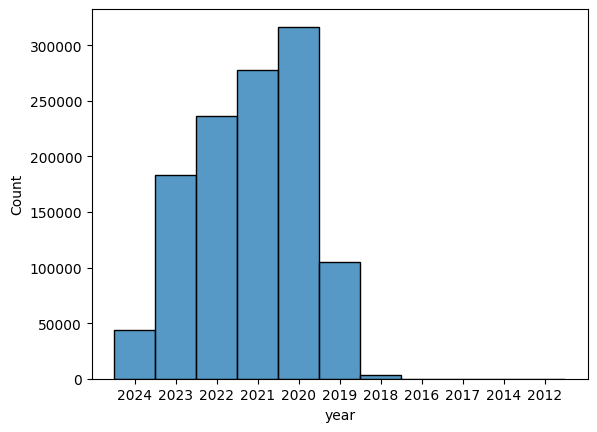

In [ ]:
import seaborn as sns


sns.histplot(years)

In [ ]:
df_metrics = dataset.metrics

df_metrics

,symbol,date,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
0,A,2024-01-31,2024,Q1,5.658703,1.187713,1.655290,1.348123,5.965870,21.119454,...,453000000.0,1.032000e+09,70.295537,58.953020,124.791946,1.280309,1.526639,0.721200,0.056238,-0.307167
1,A,2023-10-31,2023,Q4,5.780822,1.626712,1.767123,1.479452,5.445205,20.017123,...,435000000.0,1.051500e+09,68.832938,48.667529,120.038810,1.307514,1.849282,0.749758,0.081266,-0.287671
2,A,2023-07-31,2023,Q3,5.687075,0.377551,1.911565,1.636054,4.520408,18.904762,...,465500000.0,1.087500e+09,72.075359,40.118343,95.147929,1.248693,2.243363,0.945896,0.019971,-0.275510
3,A,2023-04-30,2023,Q2,5.800676,1.020270,1.344595,1.152027,3.969595,19.530405,...,509500000.0,1.107000e+09,73.436226,54.363178,125.182850,1.225553,1.655532,0.718948,0.052240,-0.192568
4,A,2023-01-31,2023,Q1,5.932432,1.189189,1.000000,0.743243,4.246622,18.949324,...,560000000.0,1.074500e+09,74.777904,61.675127,126.890863,1.203564,1.459259,0.709271,0.062756,-0.256757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61762,ZTS,2012-03-31,2012,Q1,2.197678,0.232992,-0.008396,-0.073466,0.237190,8.257559,...,207000000.0,1.146500e+09,72.893983,45.801527,281.679389,1.234670,1.965000,0.319512,0.028216,-0.065070
61763,ZTS,2011-12-31,2011,Q4,2.365600,0.018891,0.239289,0.125941,0.165823,7.808368,...,NaN,NaN,69.556344,45.966587,228.329356,1.293915,1.957944,0.394167,0.002419,-0.113347
61764,ZTS,2011-09-30,2011,Q3,2.201876,0.197308,0.379923,0.329547,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-0.050377
61765,ZTS,2011-06-30,2011,Q2,2.254351,0.138536,0.291764,0.243487,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-0.048278


In [ ]:
df_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61767 entries, 0 to 61766
Data columns (total 61 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   symbol                                  61767 non-null  object 
 1   date                                    61767 non-null  object 
 2   calendarYear                            61767 non-null  int64  
 3   period                                  61767 non-null  object 
 4   revenuePerShare                         61767 non-null  float64
 5   netIncomePerShare                       61767 non-null  float64
 6   operatingCashFlowPerShare               56836 non-null  float64
 7   freeCashFlowPerShare                    56836 non-null  float64
 8   cashPerShare                            57730 non-null  float64
 9   bookValuePerShare                       57730 non-null  float64
 10  tangibleBookValuePerShare               57730 non-null  fl

In [ ]:
import re


def snake_case(string: str):

    pattern = re.compile(r'(?<!^)(?=[A-Z])')
    string = pattern.sub('_', string).lower()

    return string

In [ ]:
string = 'salesGeneralAndAdministrativeToRevenue'

snake_case(string)

'sales_general_and_administrative_to_revenue'

In [ ]:
columns = [
    'symbol',
    'date',
    'calendarYear',
    'period',
    'revenuePerShare',
    'netIncomePerShare',
    'marketCap',
    'peRatio',
    'priceToSalesRatio',
    'pocfratio',
    'pfcfRatio',
    'pbRatio',
    'ptbRatio',
    'debtToEquity',
    'debtToAssets',
    'currentRatio',
    'interestCoverage',
    'incomeQuality',
    'salesGeneralAndAdministrativeToRevenue',
    'researchAndDdevelopementToRevenue',
    'intangiblesToTotalAssets',
    'capexToOperatingCashFlow',
    'capexToDepreciation',
    'investedCapital',
]

df = df_metrics.loc[
    (df_metrics['date'] >= config.start_date) & (df_metrics['date'] <= config.end_date),
    columns
]


df = df.rename(columns={
    **{column: snake_case(column) for column in columns},
    'symbol': 'ticker',
})

df['report_period'] = df['calendar_year'].astype(str).str.cat(df['period'], sep='-')

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['start_date'] = df['date']

levels = ['ticker', 'report_period']
df.set_index(levels, inplace=True)
df.sort_index(level=levels, ascending=True, inplace=True)

df['end_date'] = df.groupby(level=['ticker', ])['start_date'].shift(periods=-1, fill_value=config.end_date)
df['end_date'] = df['end_date'] - pd.to_timedelta(1, unit='D')

df = df.drop(columns=[
    'date',
    'calendar_year',
    'period',
])

df

revenue_per_share  net_income_per_share    market_cap  \
ticker report_period                                                          
A      2020-Q1                 4.377419              0.635484  2.559360e+10   
       2020-Q2                 4.006472              0.326861  2.368794e+10   
       2020-Q3                 4.080906              0.644013  2.976597e+10   
       2020-Q4                 4.814935              0.720779  3.144372e+10   
       2021-Q1                 5.058824              0.941176  3.697398e+10   
...                                 ...                   ...           ...   
ZTS    2022-Q4                 4.381443              0.990120  6.823368e+10   
       2023-Q1                 4.314995              1.190939  7.714494e+10   
       2023-Q2                 4.719636              1.452695  7.954380e+10   
       2023-Q3                 4.673039              1.294808  8.008299e+10   
       2023-Q4                 4.821351              1.143791  9.059283e+10   

                       pe_ratio  price_to_sales_ratio   pocfratio  \
ticker report_period                                                
A      2020-Q1        32.479188             18.860427 -433.789831   
       2020-Q2        58.633515             19.134039   75.680319   
       2020-Q3        37.394435             23.605052  102.641276   
       2020-Q4        35.409595             21.202778   83.405093   
       2021-Q1        32.095469             23.885000  155.352857   
...                         ...                   ...         ...   
ZTS    2022-Q4        37.003080             33.447882   92.083239   
       2023-Q1        34.938832             38.572470  140.519016   
       2023-Q2        29.636289             36.487981  434.665568   
       2023-Q3        33.591860             37.230588  110.611870   
       2023-Q4        43.139443             40.936661  100.995351   

                       pfcf_ratio   pb_ratio  ptb_ratio  debt_to_equity  ...  \
ticker report_period                                                     ...   
A      2020-Q1        -275.200000   5.279208   5.279208        0.507838  ...   
       2020-Q2          84.599786   4.968108   4.968108        0.521812  ...   
       2020-Q3         112.324415   5.975902   5.975902        0.466372  ...   
       2020-Q4          89.839200   6.452641   6.452641        0.484096  ...   
       2021-Q1         187.685178   7.696499   7.696499        0.520192  ...   
...                           ...        ...        ...             ...  ...   
ZTS    2022-Q4         119.708211  15.490052  15.490052        1.836549  ...   
       2023-Q1         236.640920  17.166208  17.166208        1.500223  ...   
       2023-Q2        4679.047000  17.198659  17.198659        1.458378  ...   
       2023-Q3         138.312598  15.770578  15.770578        1.328279  ...   
       2023-Q4         129.603476  18.129444  18.129444        1.323794  ...   

                      interest_coverage  income_quality  \
ticker report_period                                      
A      2020-Q1                10.750000       -0.299492   
       2020-Q2                 5.100000        3.099010   
       2020-Q3                12.105263        1.457286   
       2020-Q4                15.736842        1.698198   
       2021-Q1                17.263158        0.826389   
...                                 ...             ...   
ZTS    2022-Q4                10.580645        1.610870   
       2023-Q1                12.396825        0.996370   
       2023-Q2                15.017241        0.273134   
       2023-Q3                14.169492        1.214765   
       2023-Q4                10.582090        1.708571   

                      sales_general_and_administrative_to_revenue  \
ticker report_period                                                
A      2020-Q1                                           0.000000   
       2020-Q2                                           0.000000   
       2020

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8330 entries, ('A', '2020-Q1') to ('ZTS', '2023-Q4')
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   revenue_per_share                            8330 non-null   float64       
 1   net_income_per_share                         8330 non-null   float64       
 2   market_cap                                   8330 non-null   float64       
 3   pe_ratio                                     8330 non-null   float64       
 4   price_to_sales_ratio                         8330 non-null   float64       
 5   pocfratio                                    8330 non-null   float64       
 6   pfcf_ratio                                   8330 non-null   float64       
 7   pb_ratio                                     8330 non-null   float64       
 8   ptb_ratio                                    8330

In [ ]:
special_columns = ['start_date', 'end_date']
df_reports = df[special_columns]

df_reports

start_date   end_date
ticker report_period                      
A      2020-Q1       2020-01-31 2020-04-29
       2020-Q2       2020-04-30 2020-07-30
       2020-Q3       2020-07-31 2020-10-30
       2020-Q4       2020-10-31 2021-01-30
       2021-Q1       2021-01-31 2021-04-29
...                         ...        ...
ZTS    2022-Q4       2022-12-31 2023-03-30
       2023-Q1       2023-03-31 2023-06-29
       2023-Q2       2023-06-30 2023-09-29
       2023-Q3       2023-09-30 2023-12-30
       2023-Q4       2023-12-31 2024-04-14

[8330 rows x 2 columns]

In [ ]:
df.index

MultiIndex([(  'A', '2020-Q1'),
            (  'A', '2020-Q2'),
            (  'A', '2020-Q3'),
            (  'A', '2020-Q4'),
            (  'A', '2021-Q1'),
            (  'A', '2021-Q2'),
            (  'A', '2021-Q3'),
            (  'A', '2021-Q4'),
            (  'A', '2022-Q1'),
            (  'A', '2022-Q2'),
            ...
            ('ZTS', '2021-Q3'),
            ('ZTS', '2021-Q4'),
            ('ZTS', '2022-Q1'),
            ('ZTS', '2022-Q2'),
            ('ZTS', '2022-Q3'),
            ('ZTS', '2022-Q4'),
            ('ZTS', '2023-Q1'),
            ('ZTS', '2023-Q2'),
            ('ZTS', '2023-Q3'),
            ('ZTS', '2023-Q4')],
           names=['ticker', 'report_period'], length=8330)

In [ ]:
df.loc[pd.IndexSlice['MSFT', :], :]

revenue_per_share  net_income_per_share    market_cap  \
ticker report_period                                                          
MSFT   2020-Q3                 4.606814              1.414365  1.198911e+12   
       2020-Q4                 5.017546              1.477836  1.542606e+12   
       2021-Q1                 4.910653              1.836241  1.591357e+12   
       2021-Q2                 5.701655              2.046724  1.680383e+12   
       2021-Q3                 5.532033              2.050272  1.777470e+12   
       2021-Q4                 6.131527              2.186528  2.039064e+12   
       2022-Q1                 6.031812              2.729269  2.118065e+12   
       2022-Q2                 6.892472              2.500333  2.524082e+12   
       2022-Q3                 6.587482              2.232484  2.310167e+12   
       2022-Q4                 6.939390              2.239765  1.919547e+12   
       2023-Q1                 6.721470              2.354298  1.736735e+12   
       2023-Q2                 7.079184              2.204402  1.786899e+12   
       2023-Q3                 7.103481              2.459212  2.145240e+12   
       2023-Q4                 7.558380              2.701238  2.531574e+12   
       2024-Q1                 7.607619              3.000538  2.345707e+12   
       2024-Q2                 8.344995              2.942680  2.794729e+12   

                       pe_ratio  price_to_sales_ratio   pocfratio  pfcf_ratio  \
ticker report_period                                                            
MSFT   2020-Q3        27.876475             34.234072   68.493568   87.276073   
       2020-Q4        34.427017             40.559667   82.611568  110.747778   
       2021-Q1        28.635946             42.831372   82.304462  110.296422   
       2021-Q2        27.167805             39.009729  134.258797  201.436478   
       2021-Q3        28.748626             42.619048   80.142028  104.006438   
       2021-Q4        30.973756             44.181494   89.787067  125.419135   
       2022-Q1        25.823762             46.738861   86.310716  113.084088   
       2022-Q2        33.627519             48.795268  174.315028  292.986837   
       2022-Q3        34.525449             46.802407   91.001608  115.243282   
       2022-Q4        28.667076             37.010458   77.938504  108.094798   
       2023-Q1        24.731364             34.650160   74.865734  102.674271   
       2023-Q2        27.197851             33.876786  159.930083  364.747667   
       2023-Q3        29.308163             40.585737   87.772198  120.289352   
       2023-Q4        31.517036             45.054626   87.993547  127.683177   
       2024-Q1        26.307778             41.504446   76.699694  113.505601   
       2024-Q2        31.947065             45.061743  148.237908  306.506830   

                       pb_ratio  ptb_ratio  debt_to_equity  ...  \
ticker report_period                                        ...   
MSFT   2020-Q3        10.470751  10.470751        0.645042  ...   
       2020-Q4        13.039338  13.039338        0.600132  ...   
       2021-Q1        12.896758  12.896758        0.577874  ...   
       2021-Q2        12.902601  12.902601        0.532863  ...   
       2021-Q3        13.214899  13.214899        0.500576  ...   
       2021-Q4        14.360821  14.360821        0.477329  ...   
       2022-Q1        13.936655  13.936655        0.416758  ...   
       2022-Q2        15.774524  15.774524        0.400175  ...   
       2022-Q3        14.179414  14.179414        0.376145  ...   
       2022-Q4        11.525906  11.525906        0.367895  ...   
       2023-Q1        10.006195  10.006195        0.347315  ...   
       2023-Q2         9.757223   9.757223        0.328248  ...   
       2023-Q3        11.019145  11.019145        0.310875  ...   
       2023-Q4        12.275907  12.275907        0.290777  ...   
       2024-Q1        10.627811  10.627811        0.385064  ...   
 

In [ ]:
ticker_index = ['A', 'MSFT', 'NVDA']
report_index = ['2020-Q1', '2021-Q4', '2022-Q3']

df.loc[pd.IndexSlice[ticker_index, report_index], :]

revenue_per_share  net_income_per_share    market_cap  \
ticker report_period                                                          
A      2020-Q1                 4.377419              0.635484  2.559360e+10   
       2021-Q4                 5.478548              1.458746  4.758918e+10   
       2022-Q3                 5.765101              1.104027  3.976214e+10   
MSFT   2021-Q4                 6.131527              2.186528  2.039064e+12   
       2022-Q3                 6.587482              2.232484  2.310167e+12   
NVDA   2021-Q4                 2.020598              0.588449  3.277481e+11   
       2022-Q3                 2.842337              0.985994  6.454167e+11   

                       pe_ratio  price_to_sales_ratio   pocfratio  pfcf_ratio  \
ticker report_period                                                            
A      2020-Q1        32.479188             18.860427 -433.789831 -275.200000   
       2021-Q4        26.916957             28.668181  107.911973  125.565119   
       2022-Q3        30.214392             23.144435  121.969755  162.959590   
MSFT   2021-Q4        30.973756             44.181494   89.787067  125.419135   
       2022-Q3        34.525449             46.802407   91.001608  115.243282   
NVDA   2021-Q4        56.236809             65.510318  158.562225  183.715314   
       2022-Q3        65.484652             90.865371  424.895806  497.239391   

                       pb_ratio  ptb_ratio  debt_to_equity  ...  \
ticker report_period                                        ...   
A      2020-Q1         5.279208   5.279208        0.507838  ...   
       2021-Q4         8.830800   8.830800        0.506402  ...   
       2022-Q3         7.810281   7.810281        0.571990  ...   
MSFT   2021-Q4        14.360821  14.360821        0.477329  ...   
       2022-Q3        14.179414  14.179414        0.376145  ...   
NVDA   2021-Q4        19.401416  19.401416        0.449713  ...   
       2022-Q3        27.120629  27.120629        0.496975  ...   

                      interest_coverage  income_quality  \
ticker report_period                                      
A      2020-Q1                10.750000       -0.299492   
       2021-Q4                18.809524        0.997738   
       2022-Q3                21.631579        0.990881   
MSFT   2021-Q4                34.529837        1.379876   
       2022-Q3                40.485089        1.517575   
NVDA   2021-Q4                28.433962        1.418668   
       2022-Q3                43.080645        0.616477   

                      sales_general_and_administrative_to_revenue  \
ticker report_period                                                
A      2020-Q1                                           0.000000   
       2021-Q4                                           0.000000   
       2022-Q3                                           0.000000   
MSFT   2021-Q4                                           0.032978   
       2022-Q3                                           0.029984   
NVDA   2021-Q4                                           0.000000   
       2022-Q3                                           0.000000   

                      research_and_ddevelopement_to_revenue  \
ticker report_period                                          
A      2020-Q1                                     0.076640   
       2021-Q4                                     0.069880   
       2022-Q3                                     0.067520   
MSFT   2021-Q4                                     0.123223   
       2022-Q3                                     0.127755   
NVDA   2021-Q4                                     0.229262   
       2022-Q3                                     0.197522   

                      intangibles_to_total_assets  \
ticker report_period                                
A      2020-Q1                           0.489212   
       2021-Q4                           0.462961   
       2022-Q3                           0

In [ ]:
ticker_index = ['A', 'MSFT', 'NVDA']
report_index = ['2020-Q1', '2021-Q4', '2022-Q3']

_index = zip(ticker_index, report_index)

df.loc[_index, :]

,,revenue_per_share,net_income_per_share,market_cap,pe_ratio,price_to_sales_ratio,pocfratio,pfcf_ratio,pb_ratio,ptb_ratio,debt_to_equity,...,interest_coverage,income_quality,sales_general_and_administrative_to_revenue,research_and_ddevelopement_to_revenue,intangibles_to_total_assets,capex_to_operating_cash_flow,capex_to_depreciation,invested_capital,start_date,end_date
ticker,report_period,,,,,,,,,,,,,,,,,,,,,
A,2020-Q1,4.377419,0.635484,2.559360e+10,32.479188,18.860427,-433.789831,-275.200000,5.279208,5.279208,0.507838,...,10.750000,-0.299492,0.000000,0.076640,0.489212,0.576271,-0.430380,0.507838,2020-01-31,2020-04-29
MSFT,2021-Q4,6.131527,2.186528,2.039064e+12,30.973756,44.181494,89.787067,125.419135,14.360821,14.360821,0.477329,...,34.529837,1.379876,0.032978,0.123223,0.172303,-0.284104,-1.929426,0.477329,2021-06-30,2021-09-29
NVDA,2022-Q3,2.842337,0.985994,6.454167e+11,65.484652,90.865371,424.895806,497.239391,27.120629,27.120629,0.496975,...,43.080645,0.616477,0.000000,0.197522,0.166273,-0.145490,-0.741611,0.496975,2021-10-31,2022-01-29


In [ ]:
df = df_metrics[df_metrics['date'] >= '2020-01-01']

columns = [
    'revenuePerShare',
    'netIncomePerShare',
    'operatingCashFlowPerShare',
    'freeCashFlowPerShare',
    'cashPerShare',
    'bookValuePerShare',
    'tangibleBookValuePerShare',
    'shareholdersEquityPerShare',
    'interestDebtPerShare',
    'marketCap',
    'enterpriseValue',
    'peRatio',
    'priceToSalesRatio',
    'pocfratio',
    'pfcfRatio',
    'pbRatio',
    'ptbRatio',
    'evToSales',
    'enterpriseValueOverEBITDA',
    'evToOperatingCashFlow',
    'evToFreeCashFlow',
    'earningsYield',
    'freeCashFlowYield',
    'debtToEquity',
    'debtToAssets',
    'netDebtToEBITDA',
    'currentRatio',
    'interestCoverage',
    'incomeQuality',
    'dividendYield',
    'payoutRatio',
    'salesGeneralAndAdministrativeToRevenue',
    'researchAndDdevelopementToRevenue',
    'intangiblesToTotalAssets',
    'capexToOperatingCashFlow',
    'capexToRevenue',
    'capexToDepreciation',
    'stockBasedCompensationToRevenue',
    'grahamNumber',
    'roic',
    'returnOnTangibleAssets',
    'grahamNetNet',
    'workingCapital',
    'tangibleAssetValue',
    'netCurrentAssetValue',
    'investedCapital',
    'averageReceivables',
    'averagePayables',
    'averageInventory',
    'daysSalesOutstanding',
    'daysPayablesOutstanding',
    'daysOfInventoryOnHand',
    'receivablesTurnover',
    'payablesTurnover',
    'inventoryTurnover',
    'roe',
    'capexPerShare'
]

df

,symbol,date,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
0,A,2024-01-31,2024,Q1,5.658703,1.187713,1.655290,1.348123,5.965870,21.119454,...,453000000.0,1.032000e+09,70.295537,58.953020,124.791946,1.280309,1.526639,0.721200,0.056238,-0.307167
1,A,2023-10-31,2023,Q4,5.780822,1.626712,1.767123,1.479452,5.445205,20.017123,...,435000000.0,1.051500e+09,68.832938,48.667529,120.038810,1.307514,1.849282,0.749758,0.081266,-0.287671
2,A,2023-07-31,2023,Q3,5.687075,0.377551,1.911565,1.636054,4.520408,18.904762,...,465500000.0,1.087500e+09,72.075359,40.118343,95.147929,1.248693,2.243363,0.945896,0.019971,-0.275510
3,A,2023-04-30,2023,Q2,5.800676,1.020270,1.344595,1.152027,3.969595,19.530405,...,509500000.0,1.107000e+09,73.436226,54.363178,125.182850,1.225553,1.655532,0.718948,0.052240,-0.192568
4,A,2023-01-31,2023,Q1,5.932432,1.189189,1.000000,0.743243,4.246622,18.949324,...,560000000.0,1.074500e+09,74.777904,61.675127,126.890863,1.203564,1.459259,0.709271,0.062756,-0.256757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61726,ZTS,2021-03-31,2021,Q1,3.934805,1.175605,0.841220,0.679285,7.575184,8.599369,...,401500000.0,1.664000e+09,54.115446,56.721311,278.688525,1.663111,1.586705,0.322941,0.136708,-0.161935
61727,ZTS,2020-12-31,2020,Q4,3.800210,0.754995,1.509989,1.207150,7.575184,7.926393,...,407000000.0,1.627000e+09,50.453791,68.435940,243.793677,1.783810,1.315098,0.369165,0.095251,-0.302839
61728,ZTS,2020-09-30,2020,Q3,3.756046,1.007361,1.181914,0.919033,7.684543,7.575184,...,346000000.0,1.605000e+09,50.996641,58.846154,268.021978,1.764822,1.529412,0.335793,0.132982,-0.262881
61729,ZTS,2020-06-30,2020,Q2,3.256890,0.793183,0.921523,0.732169,7.054492,6.273932,...,300000000.0,1.532500e+09,57.209302,66.851441,316.097561,1.573171,1.346269,0.284722,0.126425,-0.189354


In [ ]:
df_metrics.columns[np.where(~ df_metrics.isna().any())]

Index(['symbol', 'date', 'calendarYear', 'period', 'revenuePerShare',
       'netIncomePerShare', 'marketCap', 'peRatio', 'priceToSalesRatio',
       'pocfratio', 'pfcfRatio', 'pbRatio', 'ptbRatio', 'debtToEquity',
       'debtToAssets', 'currentRatio', 'interestCoverage', 'incomeQuality',
       'salesGeneralAndAdministrativeToRevenue',
       'researchAndDdevelopementToRevenue', 'intangiblesToTotalAssets',
       'capexToOperatingCashFlow', 'capexToDepreciation', 'investedCapital'],
      dtype='object')

In [ ]:
(df.isna().any() == False).index.tolist()

['symbol',
 'date',
 'calendarYear',
 'period',
 'revenuePerShare',
 'netIncomePerShare',
 'operatingCashFlowPerShare',
 'freeCashFlowPerShare',
 'cashPerShare',
 'bookValuePerShare',
 'tangibleBookValuePerShare',
 'shareholdersEquityPerShare',
 'interestDebtPerShare',
 'marketCap',
 'enterpriseValue',
 'peRatio',
 'priceToSalesRatio',
 'pocfratio',
 'pfcfRatio',
 'pbRatio',
 'ptbRatio',
 'evToSales',
 'enterpriseValueOverEBITDA',
 'evToOperatingCashFlow',
 'evToFreeCashFlow',
 'earningsYield',
 'freeCashFlowYield',
 'debtToEquity',
 'debtToAssets',
 'netDebtToEBITDA',
 'currentRatio',
 'interestCoverage',
 'incomeQuality',
 'dividendYield',
 'payoutRatio',
 'salesGeneralAndAdministrativeToRevenue',
 'researchAndDdevelopementToRevenue',
 'intangiblesToTotalAssets',
 'capexToOperatingCashFlow',
 'capexToRevenue',
 'capexToDepreciation',
 'stockBasedCompensationToRevenue',
 'grahamNumber',
 'roic',
 'returnOnTangibleAssets',
 'grahamNetNet',
 'workingCapital',
 'tangibleAssetValue',
 'ne

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8330 entries, 0 to 61730
Data columns (total 61 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   symbol                                  8330 non-null   object 
 1   date                                    8330 non-null   object 
 2   calendarYear                            8330 non-null   int64  
 3   period                                  8330 non-null   object 
 4   revenuePerShare                         8330 non-null   float64
 5   netIncomePerShare                       8330 non-null   float64
 6   operatingCashFlowPerShare               8326 non-null   float64
 7   freeCashFlowPerShare                    8326 non-null   float64
 8   cashPerShare                            8320 non-null   float64
 9   bookValuePerShare                       8320 non-null   float64
 10  tangibleBookValuePerShare               8320 non-null   float64


In [ ]:
df[df['enterpriseValue'].isna()]

,symbol,date,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
476,ABNB,2020-03-31,2020,Q1,1.585531,-0.641507,-1.073237,-1.102745,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-0.029508
8415,BLK,2024-03-31,2024,Q1,32.945528,10.578346,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN
16217,DASH,2020-03-31,2020,Q1,1.278497,-0.455597,-0.441470,-0.554486,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-0.113016
24566,GEHC,2022-03-31,2022,Q1,9.567636,0.856968,1.031005,0.810705,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-0.220300
24722,GFS,2021-03-31,2021,Q1,2.666187,-0.236911,0.278276,-0.289558,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-0.567834
24724,GFS,2020-09-30,2020,Q3,2.051347,-0.550912,0.502025,0.270755,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-0.231270
33454,KVUE,2022-06-30,2022,Q2,2.013793,0.319751,0.427216,0.386983,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-0.040234
33455,KVUE,2022-03-31,2022,Q1,1.900504,0.279517,0.178933,0.159346,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-0.019587
41462,NSC,2024-03-31,2024,Q1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000
51086,SOLV,2022-09-30,2022,Q3,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000


In [ ]:
df[df['operatingCashFlowPerShare'].isna()]

,symbol,date,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
8415,BLK,2024-03-31,2024,Q1,32.945528,10.578346,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.000000,NaN
31903,JPM,2024-03-31,2024,Q1,22.793384,4.586528,NaN,NaN,-7.822439,115.750438,...,8.098000e+10,-9.281730e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.039624,NaN
51824,STT,2024-03-31,2024,Q1,17.586617,1.533158,NaN,NaN,-11.301661,80.906385,...,0.000000e+00,-6.432550e+10,0.0,0.0,0.0,0.0,0.0,0.0,0.018950,NaN
59608,WFC,2024-03-31,2024,Q1,8.841325,1.297435,NaN,NaN,-8.477290,50.825258,...,0.000000e+00,-2.623070e+11,0.0,0.0,0.0,0.0,0.0,0.0,0.025527,NaN


In [ ]:
df_metrics.columns

Index(['symbol', 'date', 'calendarYear', 'period', 'revenuePerShare',
       'netIncomePerShare', 'operatingCashFlowPerShare',
       'freeCashFlowPerShare', 'cashPerShare', 'bookValuePerShare',
       'tangibleBookValuePerShare', 'shareholdersEquityPerShare',
       'interestDebtPerShare', 'marketCap', 'enterpriseValue', 'peRatio',
       'priceToSalesRatio', 'pocfratio', 'pfcfRatio', 'pbRatio', 'ptbRatio',
       'evToSales', 'enterpriseValueOverEBITDA', 'evToOperatingCashFlow',
       'evToFreeCashFlow', 'earningsYield', 'freeCashFlowYield',
       'debtToEquity', 'debtToAssets', 'netDebtToEBITDA', 'currentRatio',
       'interestCoverage', 'incomeQuality', 'dividendYield', 'payoutRatio',
       'salesGeneralAndAdministrativeToRevenue',
       'researchAndDdevelopementToRevenue', 'intangiblesToTotalAssets',
       'capexToOperatingCashFlow', 'capexToRevenue', 'capexToDepreciation',
       'stockBasedCompensationToRevenue', 'grahamNumber', 'roic',
       'returnOnTangibleAssets', 'gr

In [ ]:
df_metrics['date'].unique().shape

(2391,)

In [ ]:
df_metrics[df_metrics['symbol'] == 'A'].sort_values(by='date')

,symbol,date,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
100,A,1999-01-31,1999,Q1,4.102973,0.170000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
99,A,1999-04-30,1999,Q2,4.480892,0.350000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
98,A,1999-07-31,1999,Q3,4.637778,0.300000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
97,A,1999-10-31,1999,Q4,5.576310,0.332574,NaN,NaN,0.000000,7.703872,...,NaN,NaN,60.110294,0.000000,0.000000,1.497248,0.000000,0.000000,0.043170,NaN
96,A,2000-01-31,2000,Q1,5.116173,0.298405,0.874715,0.667426,3.211845,10.218679,...,406500000.0,1.533000e+09,57.902939,23.508621,121.577586,1.554325,3.828383,0.740268,0.029202,-0.207289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,A,2023-01-31,2023,Q1,5.932432,1.189189,1.000000,0.743243,4.246622,18.949324,...,560000000.0,1.074500e+09,74.777904,61.675127,126.890863,1.203564,1.459259,0.709271,0.062756,-0.256757
3,A,2023-04-30,2023,Q2,5.800676,1.020270,1.344595,1.152027,3.969595,19.530405,...,509500000.0,1.107000e+09,73.436226,54.363178,125.182850,1.225553,1.655532,0.718948,0.052240,-0.192568
2,A,2023-07-31,2023,Q3,5.687075,0.377551,1.911565,1.636054,4.520408,18.904762,...,465500000.0,1.087500e+09,72.075359,40.118343,95.147929,1.248693,2.243363,0.945896,0.019971,-0.275510
1,A,2023-10-31,2023,Q4,5.780822,1.626712,1.767123,1.479452,5.445205,20.017123,...,435000000.0,1.051500e+09,68.832938,48.667529,120.038810,1.307514,1.849282,0.749758,0.081266,-0.287671


In [ ]:
df_metrics[df_metrics['symbol'] == 'MSFT'].sort_values(by='date')

,symbol,date,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
39444,MSFT,1985-09-30,1986,Q1,0.005985,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
39443,MSFT,1985-12-31,1986,Q2,0.005985,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
39442,MSFT,1986-03-31,1986,Q3,0.007102,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
39441,MSFT,1986-06-30,1986,Q4,0.008430,0.000000,NaN,NaN,0.013987,0.018972,...,NaN,NaN,50.161551,0.000000,0.000000,1.794203,0.000000,0.000000,0.000000,NaN
39440,MSFT,1986-09-30,1987,Q1,0.009098,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39295,MSFT,2022-12-31,2023,Q2,7.079184,2.204402,1.499530,0.657496,13.354986,24.578714,...,1.598150e+10,3.624000e+09,61.140349,79.017612,15.336231,1.472023,1.138987,5.868456,0.089687,-0.842035
39294,MSFT,2023-03-31,2023,Q3,7.103481,2.459212,3.284639,2.396721,14.034001,26.163553,...,1.532950e+10,2.928500e+09,63.715307,85.407366,16.054688,1.412533,1.053773,5.605839,0.093994,-0.887918
39293,MSFT,2023-06-30,2023,Q4,7.558380,2.701238,3.870056,2.667070,14.966640,27.740517,...,1.670000e+10,2.688500e+09,77.985371,96.966359,13.396844,1.154063,0.928157,6.718000,0.097375,-1.202986
39292,MSFT,2023-09-30,2024,Q1,7.607619,3.000538,4.116705,2.781801,19.376094,29.709786,...,1.870100e+10,2.750000e+09,58.845480,106.589989,16.562385,1.529429,0.844357,5.434000,0.100995,-1.334904


In [ ]:
df_metrics[df_metrics['symbol'] == 'NVDA'].sort_values(by='date')

,symbol,date,calendarYear,period,revenuePerShare,netIncomePerShare,operatingCashFlowPerShare,freeCashFlowPerShare,cashPerShare,bookValuePerShare,...,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover,payablesTurnover,inventoryTurnover,roe,capexPerShare
42137,NVDA,1999-05-02,2000,Q1,0.050548,0.004485,0.002421,0.000641,0.036879,0.054607,...,NaN,NaN,43.352113,55.995475,30.950226,2.076023,1.607273,2.907895,0.082138,-0.001780
42136,NVDA,1999-08-01,2000,Q2,0.058238,0.005002,-0.002464,-0.004107,0.034943,0.061598,...,3.115000e+07,1.180000e+07,57.923077,66.355932,16.016949,1.553785,1.356322,5.619048,0.081212,-0.001643
42135,NVDA,1999-10-31,2000,Q3,0.068666,0.007504,0.007433,0.003752,0.039076,0.069657,...,3.890000e+07,1.005000e+07,52.329897,67.187500,18.281250,1.719858,1.339535,4.923077,0.107724,-0.003681
42134,NVDA,2000-01-30,2000,Q4,0.071238,0.008100,0.002941,0.001997,0.034177,0.069130,...,5.395000e+07,2.465000e+07,47.102804,76.054688,44.062500,1.910714,1.183359,2.042553,0.117175,-0.000943
42133,NVDA,2000-04-30,2001,Q1,0.097645,0.012026,0.006988,0.002088,0.177425,0.106827,...,6.671350e+07,4.642050e+07,43.640147,68.623072,55.318446,2.062321,1.311512,1.626944,0.112573,-0.004900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42042,NVDA,2023-01-29,2023,Q4,2.455763,0.573864,0.912744,0.706169,5.396104,8.969562,...,1.342000e+09,4.806500e+09,56.921170,48.408476,209.337241,1.581134,1.859179,0.429928,0.063979,-0.206575
42041,NVDA,2023-04-30,2024,Q1,2.911741,0.827126,1.178543,1.078138,6.202429,9.927126,...,1.167000e+09,4.885000e+09,51.056730,40.365566,163.125000,1.762745,2.229623,0.551724,0.083320,-0.100405
42040,NVDA,2023-07-30,2024,Q2,5.461787,2.502224,2.566923,2.450061,6.479175,11.120501,...,1.535000e+09,4.465000e+09,47.082254,42.919654,96.096415,1.911548,2.096941,0.936559,0.225010,-0.116862
42039,NVDA,2023-10-29,2024,Q3,7.341977,3.745138,2.970827,2.858185,7.407212,13.478525,...,2.154500e+09,4.549000e+09,41.269868,45.381356,91.125000,2.180768,1.983193,0.987654,0.277860,-0.112642


## Model

In [ ]:
batch = {
    'past_values': df[]
}

output = model(
    past_values=batch['past_values'],
    #past_time_features=batch['past_time_features'],
    #past_observed_mask=batch['past_observed_mask'],
    static_categorical_features=batch['static_categorical_features']
    #if config.num_static_categorical_features > 0
    #else None,
    #static_real_features=batch['static_real_features']
    #if config.num_static_real_features > 0
    #else None,
    future_values=batch['future_values'],
    future_time_features=batch['future_time_features'],
    future_observed_mask=batch['future_observed_mask'],
    output_hidden_states=True,
)

output

## Debug

<Axes: xlabel='title', ylabel='Count'>

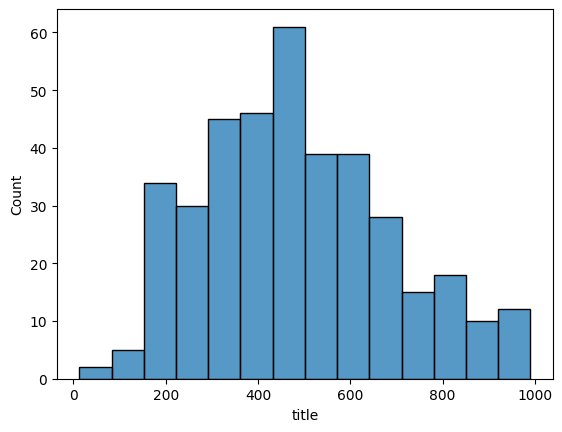

In [ ]:
import seaborn as sns


sns.histplot(news_count[news_count < 1000])

<Axes: xlabel='title', ylabel='Count'>

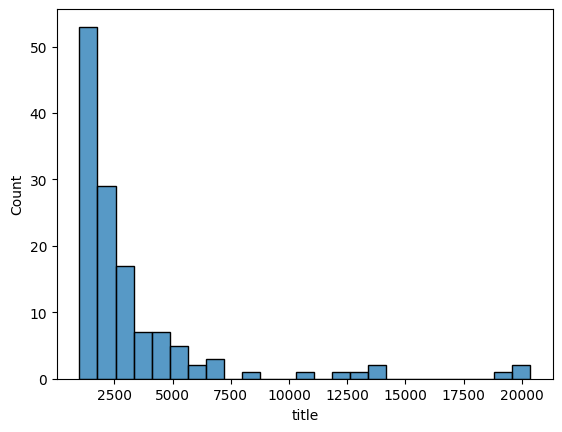

In [ ]:
sns.histplot(news_count[news_count > 1000])

In [ ]:
news_count = data.news['title'].groupby(level='ticker').count()

In [ ]:
news_count[news_count < 300].shape

(72,)

<Axes: xlabel='title', ylabel='Count'>

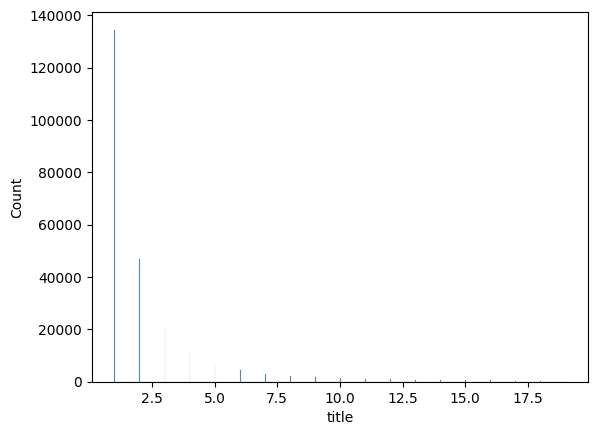

In [ ]:
sns.histplot(news_daily_count[news_daily_count < 20])

In [ ]:
features = dict()

# Profile
features['static_categorical_features'] = ['symbol', 'industry', 'sector', 'country']
features['static_real_features'] = ['age_ipo', ]

# Metrics
features['dynamic_real_features'] = [
    'revenuePerShare',
    'netIncomePerShare',
    'marketCap',
    'peRatio',
    'priceToSalesRatio',
    'pocfratio',
    'pfcfRatio',
    'pbRatio',
    'ptbRatio',
    'debtToEquity',
    'debtToAssets',
    'currentRatio',
    'interestCoverage',
    'incomeQuality',
    'salesGeneralAndAdministrativeToRevenue',
    'researchAndDdevelopementToRevenue',
    'intangiblesToTotalAssets',
    'capexToOperatingCashFlow',
    'capexToDepreciation',
    'investedCapital',
]

# News
features['value_features'] = [
    'open',
    'close',
    'low',
    'high',
    'volume'
]

# Calendar
features['time_features'] = [
    'days_in_month',
    'is_month_end',
    'is_quarter_end',
    'age',
    'weekday_Monday',
    'weekday_Saturday',
    'weekday_Sunday',
    'weekday_Thursday',
    'weekday_Tuesday',
    'weekday_Wednesday',
    'month_August',
    'month_December',
    'month_February',
    'month_January',
    'month_July',
    'month_June',
    'month_March',
    'month_May',
    'month_November',
    'month_October',
    'month_September',
    'quarter_2',
    'quarter_3',
    'quarter_4',
]

import yaml

with open('features.yaml', 'w') as file:
    yaml.dump(features, file)

In [ ]:
summary(model)

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               23,440,896
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            2,307
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               23,440,896
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            2,307
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0

In [ ]:
isinstance(model, nn.Module)

True

In [ ]:
dir(model)

In [ ]:
summary(model)

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               23,440,896
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            2,307
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               23,440,896
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            2,307
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,